In [2]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#c8abc9','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V3

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']

animals = np.concatenate((dualanimalnames,['DS_15','DS_19']))

# act_directory = 'C:\\Users\insan\\Desktop\\Analysis_Cache_Aug23'
act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'


stdfont = 14
stdyfrac = 0.06

In [3]:
animals

array(['BS_40', 'BS_41', 'BS_42', 'BS_49', 'BS_50', 'BS_51', 'BS_56',
       'BS_59', 'BS_67', 'BS_70', 'BS_72', 'BS_87', 'BS_108', 'DS_15',
       'DS_19'], dtype='<U6')

In [4]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scala

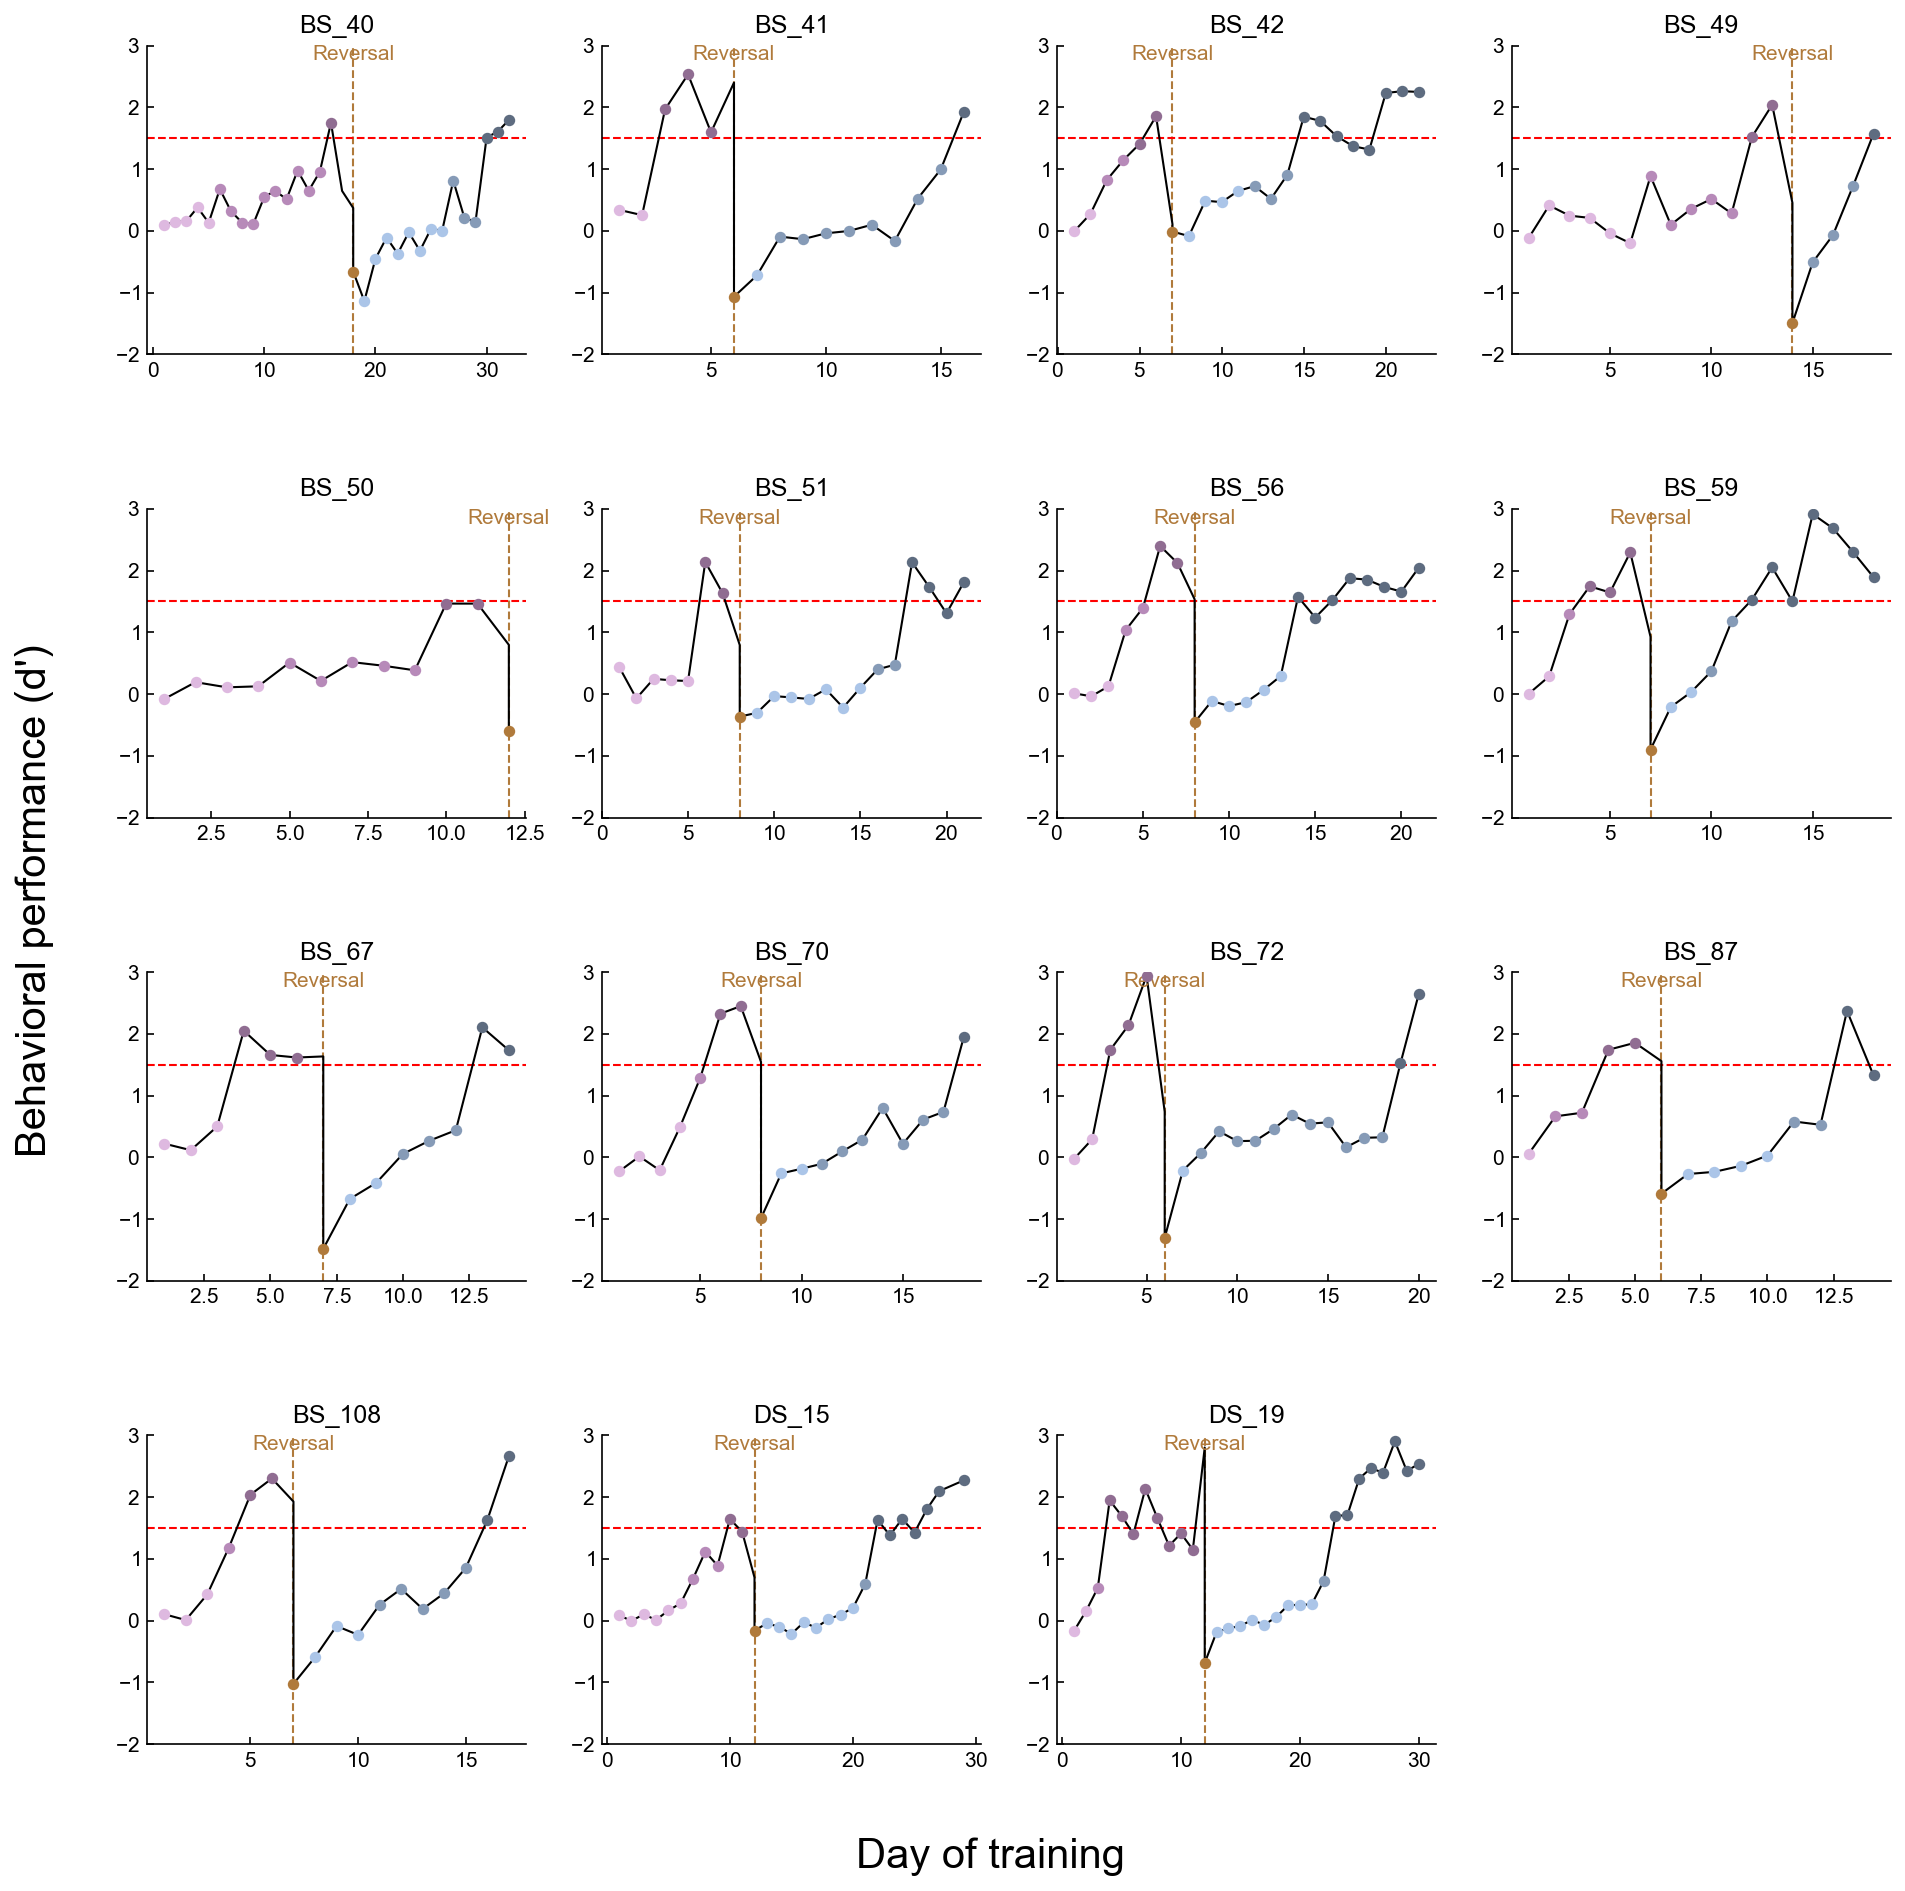

In [5]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)

In [6]:
#1 hit
#2 Miss
#3 False Alarm
#4 Correct Rejection

#go: 1,3

#pre target 11k, nontarget 5k
    
    

In [7]:
#example 1 animal, 1 session
# session1_trials = np.array(animalBehaviors['BS_49'].sessions[1].outcomes)
# session1_go_trials = []
# for idx, outcome in enumerate(session1_trials):
#     if outcome == 1 or outcome == 3:
#         session1_go_trials.append(idx)

# print(len(session1_go_trials))
# session1_responsetimes = animalBehaviors['BS_49'].sessions[1].response_time
# session1_responsetimes = np.array(session1_responsetimes)
# print(len(session1_responsetimes))
# session1_go_responsetimes = [session1_responsetimes[i] for i in session1_go_trials]
# print(len(session1_go_responsetimes))

# session1_tones = np.array(animalBehaviors['BS_49'].sessions[1].tones)
# session1_go_tones = [session1_tones[i] for i in session1_go_trials]
# print(len(session1_go_tones))

# session1_go_5k = []
# session1_go_11k = []
# for idx, tone in enumerate(session1_go_tones):
#     if tone<6000:
#         session1_go_5k.append(idx)
#     else:
#         session1_go_11k.append(idx)

# if animalBehaviors['BS_49'].sessions[1].type == 'prereversal':
#     session1_go_target_reactiontimes = [session1_go_responsetimes[i] for i in session1_go_11k]
#     session1_go_nontarget_reactiontimes = [session1_go_responsetimes[i] for i in session1_go_5k]
# else:
#     session1_go_target_reactiontimes = [session1_go_responsetimes[i] for i in session1_go_5k]
#     session1_go_nontarget_reactiontimes = [session1_go_responsetimes[i] for i in session1_go_11k]

# print(len(session1_go_target_reactiontimes))
# print(len(session1_go_nontarget_reactiontimes))

In [8]:
learning_phases['BS_40'].pre_early_days

array([1, 2, 3, 4, 5])

In [9]:
learning_phases['DS_19'].pre_expert_days

array([ 4,  5,  6,  7,  8,  9, 10, 11])

### Behavior trim -- Seems to incorrectly calculate False Alarms

In [9]:
def get_outcomes(animal,day,noTrim=False):
    outcomes = np.array(animalBehaviors[animal].sessions[day].outcomes)
    valid_trials_mask = np.ones_like(outcomes,dtype='bool')
    
    if not noTrim:
        try:
            #We will trim for active trials only on expert days
            exceptionTrials = ilep.exceptionsForSpecificBehaviorDays(animal,day)
            if not exceptionTrials is None:
                valid_trials_mask = exceptionTrials
                outcomes = outcomes[valid_trials_mask]
            elif day in learning_phases[animal].post_expert_days:
                valid_trials_mask = ilep.getActiveTrials(outcomes)
                outcomes = outcomes[valid_trials_mask]
        except Exception as e:
            print(f"{animal} session {day}: {e}")
            return np.nan
    else:
        outcomes = np.array(animalBehaviors[animal].sessions[day].outcomes)
    return outcomes,valid_trials_mask



### Behavior trim V2 (run data qualoty check first)

In [12]:
with open('C:\\Users\\insan\\Desktop\\trialsToUsePerDay', 'rb') as f:
    trialsPerDayLoaded = pickle.load(f)

In [13]:
def get_outcomes(animal,day,noTrim=False):
    outcomes = np.array(animalBehaviors[animal].sessions[day].outcomes)
    valid_trials_mask = np.ones_like(outcomes,dtype='bool')
    
    if not noTrim:
        try:
            valid_trials_mask = trialsPerDayLoaded[animal][day]
            outcomes = outcomes[valid_trials_mask]
        except Exception as e:
            print(f"{animal} session {day}: {e}")
            return np.nan
    else:
        outcomes = np.array(animalBehaviors[animal].sessions[day].outcomes)
    return outcomes,valid_trials_mask


In [14]:
animal = 'BS_40'
get_outcomes(animal,1,noTrim=False)[0]

array([2, 1, 2, 1, 1, 2, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 4, 1, 1, 1, 1, 1,
       1, 3, 3, 3, 1, 3, 3, 1, 4, 1, 3, 1, 1, 4, 1, 3, 1, 3, 3, 1, 3, 3,
       1, 1, 3, 3, 1, 1, 3, 2, 1, 3, 1, 3, 1, 1, 3, 4, 3, 2, 1, 2, 1, 3,
       3, 4, 3, 1, 1, 4, 1, 2, 4, 1, 2, 4, 3, 3, 1, 4, 4, 4, 3, 2, 1, 1,
       4, 1, 1, 4, 4, 3, 1, 4, 2, 3, 2, 1, 2, 1, 4, 4, 3, 2, 1, 4, 4, 1,
       2, 1, 1, 4, 1, 3, 3, 4, 3, 1, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1,
       3, 3, 3, 4, 3, 1, 1, 2, 3, 1, 3, 3, 4, 3, 1, 1, 1, 2, 1, 1, 3, 1,
       3, 3, 1, 1, 3, 3, 2, 4, 1, 2, 4, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 4,
       3, 1, 2, 1, 3, 4, 3, 1, 1, 4, 1, 2, 3, 1, 1, 4, 3, 2, 1, 3, 1, 3,
       3, 1, 1, 4, 1, 3, 1, 3, 3, 1, 2, 3, 1, 1, 3, 3, 3, 1, 4, 3, 1, 1,
       2, 3, 4, 3, 3, 1, 1, 3, 2, 2, 4, 2, 1, 4, 3, 3, 3, 1, 1, 1, 1, 1,
       4, 4, 2, 4, 4, 2, 1, 4, 4, 2, 4, 4, 2, 2, 2, 4, 2, 4, 2, 2, 4, 1,
       3, 2, 4, 2, 3, 4, 2, 2, 2, 4, 1, 1, 2, 1, 1, 1, 3, 1, 3, 1, 4, 4,
       1, 4, 3, 3, 1, 1, 2, 1, 3, 3, 1, 4, 1, 1, 3,

In [15]:
get_outcomes(animal,1,noTrim=False)

(array([2, 1, 2, 1, 1, 2, 3, 3, 3, 1, 3, 1, 3, 1, 3, 3, 4, 1, 1, 1, 1, 1,
        1, 3, 3, 3, 1, 3, 3, 1, 4, 1, 3, 1, 1, 4, 1, 3, 1, 3, 3, 1, 3, 3,
        1, 1, 3, 3, 1, 1, 3, 2, 1, 3, 1, 3, 1, 1, 3, 4, 3, 2, 1, 2, 1, 3,
        3, 4, 3, 1, 1, 4, 1, 2, 4, 1, 2, 4, 3, 3, 1, 4, 4, 4, 3, 2, 1, 1,
        4, 1, 1, 4, 4, 3, 1, 4, 2, 3, 2, 1, 2, 1, 4, 4, 3, 2, 1, 4, 4, 1,
        2, 1, 1, 4, 1, 3, 3, 4, 3, 1, 3, 1, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1,
        3, 3, 3, 4, 3, 1, 1, 2, 3, 1, 3, 3, 4, 3, 1, 1, 1, 2, 1, 1, 3, 1,
        3, 3, 1, 1, 3, 3, 2, 4, 1, 2, 4, 3, 1, 3, 3, 1, 3, 1, 3, 3, 1, 4,
        3, 1, 2, 1, 3, 4, 3, 1, 1, 4, 1, 2, 3, 1, 1, 4, 3, 2, 1, 3, 1, 3,
        3, 1, 1, 4, 1, 3, 1, 3, 3, 1, 2, 3, 1, 1, 3, 3, 3, 1, 4, 3, 1, 1,
        2, 3, 4, 3, 3, 1, 1, 3, 2, 2, 4, 2, 1, 4, 3, 3, 3, 1, 1, 1, 1, 1,
        4, 4, 2, 4, 4, 2, 1, 4, 4, 2, 4, 4, 2, 2, 2, 4, 2, 4, 2, 2, 4, 1,
        3, 2, 4, 2, 3, 4, 2, 2, 2, 4, 1, 1, 2, 1, 1, 1, 3, 1, 3, 1, 4, 4,
        1, 4, 3, 3, 1, 1, 2, 1, 3, 3, 

### Hit rate and False alarm rate (session average)

In [16]:
def get_animal_session_outcomes(animal,session_num):
    print(animal)
    print(session_num)
    #session_trials = np.array(animalBehaviors[animal].sessions[session_num].outcomes)
    session_trials = get_outcomes(animal,session_num,noTrim=False)[0] #trim

    print('session trials:' + str(len(session_trials)))

    session_hit_trials = []
    session_miss_trials = []
    
    session_fa_trials = []
    session_cr_trials = []

    for idx, outcome in enumerate(session_trials):
        if outcome == 1:
            session_hit_trials.append(idx)
        if outcome == 2:
            session_miss_trials.append(idx)
        if outcome == 3:
            session_fa_trials.append(idx)
        if outcome == 4:
            session_cr_trials.append(idx)

    session_hit = len(session_hit_trials)
    session_miss = len(session_miss_trials)
    session_fa = len(session_fa_trials)
    session_cr = len(session_cr_trials)
    
    session_hit_rate = session_hit/(session_hit + session_miss)*100
    session_fa_rate = session_fa/(session_fa + session_cr)*100
    
    session_go_rate = (session_hit + session_fa)/ (session_hit + session_miss + session_fa + session_cr)*100
    return session_hit_rate,session_fa_rate,session_go_rate

In [17]:
hit_preearly = dict()
hit_prelate = dict()
hit_preexpert = dict()
hit_postearly = dict()
hit_postlate = dict()
hit_postexpert = dict()

fa_preearly = dict()
fa_prelate = dict()
fa_preexpert = dict()
fa_postearly = dict()
fa_postlate = dict()
fa_postexpert = dict()

mean_hit_preearly = dict()
mean_hit_prelate = dict()
mean_hit_preexpert = dict()
mean_hit_postearly = dict()
mean_hit_postlate = dict()
mean_hit_postexpert = dict()

mean_fa_preearly = dict()
mean_fa_prelate = dict()
mean_fa_preexpert = dict()
mean_fa_postearly = dict()
mean_fa_postlate = dict()
mean_fa_postexpert = dict()

go_preearly = dict()
go_prelate = dict()
go_preexpert = dict()
go_postearly = dict()
go_postlate = dict()
go_postexpert = dict()

mean_go_preearly = dict()
mean_go_prelate = dict()
mean_go_preexpert = dict()
mean_go_postearly = dict()
mean_go_postlate = dict()
mean_go_postexpert = dict()

for animal in animals:
    hit_preearly[animal] = []
    hit_prelate[animal] = []
    hit_preexpert[animal] = []
    hit_postearly[animal] = []
    hit_postlate[animal] = []
    hit_postexpert[animal] = []
    
    fa_preearly[animal] = []
    fa_prelate[animal] = []
    fa_preexpert[animal] = []
    fa_postearly[animal] = []
    fa_postlate[animal] = []
    fa_postexpert[animal] = []
    
    mean_hit_preearly[animal] = []
    mean_hit_prelate[animal] = []
    mean_hit_preexpert[animal] = []
    mean_hit_postearly[animal] = []
    mean_hit_postlate[animal] = []
    mean_hit_postexpert[animal] = []
    
    mean_fa_preearly[animal] = []
    mean_fa_prelate[animal] = []
    mean_fa_preexpert[animal] = []
    mean_fa_postearly[animal] = []
    mean_fa_postlate[animal] = []
    mean_fa_postexpert[animal] = []
    
    go_preearly[animal] = []
    go_prelate[animal] = []
    go_preexpert[animal] = []
    go_postearly[animal] = []
    go_postlate[animal] = []
    go_postexpert[animal] = []
    
    mean_go_preearly[animal] = []
    mean_go_prelate[animal] = []
    mean_go_preexpert[animal] = []
    mean_go_postearly[animal] = []
    mean_go_postlate[animal] = []
    mean_go_postexpert[animal] = []

In [37]:
for animal in animals:
    #DS_19 miss reaction time data since session11 so I will only include sessions before that
#     if animal == 'DS_19':
#         continue
    #Disregard this for outcome rate    
    
    try:
        for i in range(1,len(animalBehaviors[animal].sessions)+1):
            if i in learning_phases[animal].pre_early_days:
                session_hit_rate = get_animal_session_outcomes(animal,i)[0]
                hit_preearly[animal].append(session_hit_rate)
                session_fa_rate = get_animal_session_outcomes(animal,i)[1]
                fa_preearly[animal].append(session_fa_rate)
                session_go_rate =  get_animal_session_outcomes(animal,i)[2]
                go_preearly[animal].append(session_go_rate)
                
            if i in learning_phases[animal].pre_late_days:
                session_hit_rate = get_animal_session_outcomes(animal,i)[0]
                hit_prelate[animal].append(session_hit_rate)
                session_fa_rate = get_animal_session_outcomes(animal,i)[1]
                fa_prelate[animal].append(session_fa_rate)
                session_go_rate =  get_animal_session_outcomes(animal,i)[2]
                go_prelate[animal].append(session_go_rate)
                
            if i in learning_phases[animal].pre_expert_days:
                session_hit_rate = get_animal_session_outcomes(animal,i)[0]
                hit_preexpert[animal].append(session_hit_rate)
                session_fa_rate = get_animal_session_outcomes(animal,i)[1]
                fa_preexpert[animal].append(session_fa_rate)
                session_go_rate =  get_animal_session_outcomes(animal,i)[2]
                go_preexpert[animal].append(session_go_rate)
                
            if i in learning_phases[animal].post_early_days:
                session_hit_rate = get_animal_session_outcomes(animal,i)[0]
                hit_postearly[animal].append(session_hit_rate)
                session_fa_rate = get_animal_session_outcomes(animal,i)[1]
                fa_postearly[animal].append(session_fa_rate)
                session_go_rate =  get_animal_session_outcomes(animal,i)[2]
                go_postearly[animal].append(session_go_rate)
                
            if i in learning_phases[animal].post_late_days:
                session_hit_rate = get_animal_session_outcomes(animal,i)[0]
                hit_postlate[animal].append(session_hit_rate)
                session_fa_rate = get_animal_session_outcomes(animal,i)[1]
                fa_postlate[animal].append(session_fa_rate)
                session_go_rate =  get_animal_session_outcomes(animal,i)[2]
                go_postlate[animal].append(session_go_rate)
                
            if i in learning_phases[animal].post_expert_days:
                session_hit_rate = get_animal_session_outcomes(animal,i)[0]
                hit_postexpert[animal].append(session_hit_rate)
                session_fa_rate = get_animal_session_outcomes(animal,i)[1]
                fa_postexpert[animal].append(session_fa_rate)
                session_go_rate =  get_animal_session_outcomes(animal,i)[2]
                go_postexpert[animal].append(session_go_rate)

    except Exception as e:
        print('e')
        print(animal)
        print(i)
        

BS_40
1
session trials:374
BS_40
1
session trials:374
BS_40
1
session trials:374
BS_40
2
session trials:370
BS_40
2
session trials:370
BS_40
2
session trials:370
BS_40
3
session trials:452
BS_40
3
session trials:452
BS_40
3
session trials:452
BS_40
4
session trials:445
BS_40
4
session trials:445
BS_40
4
session trials:445
BS_40
5
session trials:200
BS_40
5
session trials:200
BS_40
5
session trials:200
BS_40
6
session trials:392
BS_40
6
session trials:392
BS_40
6
session trials:392
BS_40
7
session trials:438
BS_40
7
session trials:438
BS_40
7
session trials:438
BS_40
8
session trials:500
BS_40
8
session trials:500
BS_40
8
session trials:500
BS_40
9
session trials:504
BS_40
9
session trials:504
BS_40
9
session trials:504
BS_40
10
session trials:599
BS_40
10
session trials:599
BS_40
10
session trials:599
BS_40
11
session trials:600
BS_40
11
session trials:600
BS_40
11
session trials:600
BS_40
12
session trials:493
BS_40
12
session trials:493
BS_40
12
session trials:493
BS_40
13
session tr

In [19]:
animal = 'DS_19'
for i in range(1,11):
    if i in learning_phases[animal].pre_early_days:
        session_hit_rate = get_animal_session_outcomes(animal,i)[0]
        hit_preearly[animal].append(session_hit_rate)
        session_fa_rate = get_animal_session_outcomes(animal,i)[1]
        fa_preearly[animal].append(session_fa_rate)
        session_go_rate =  get_animal_session_outcomes(animal,i)[2]
        go_preearly[animal].append(session_go_rate)
                
    if i in learning_phases[animal].pre_late_days:
        session_hit_rate = get_animal_session_outcomes(animal,i)[0]
        hit_prelate[animal].append(session_hit_rate)
        session_fa_rate = get_animal_session_outcomes(animal,i)[1]
        fa_prelate[animal].append(session_fa_rate)
        session_go_rate =  get_animal_session_outcomes(animal,i)[2]
        go_prelate[animal].append(session_go_rate)

    if i in learning_phases[animal].pre_expert_days:
        session_hit_rate = get_animal_session_outcomes(animal,i)[0]
        hit_preexpert[animal].append(session_hit_rate)
        session_fa_rate = get_animal_session_outcomes(animal,i)[1]
        fa_preexpert[animal].append(session_fa_rate)
        session_go_rate =  get_animal_session_outcomes(animal,i)[2]
        go_preexpert[animal].append(session_go_rate)

    if i in learning_phases[animal].post_early_days:
        session_hit_rate = get_animal_session_outcomes(animal,i)[0]
        hit_postearly[animal].append(session_hit_rate)
        session_fa_rate = get_animal_session_outcomes(animal,i)[1]
        fa_postearly[animal].append(session_fa_rate)
        session_go_rate =  get_animal_session_outcomes(animal,i)[2]
        go_postearly[animal].append(session_go_rate)

    if i in learning_phases[animal].post_late_days:
        session_hit_rate = get_animal_session_outcomes(animal,i)[0]
        hit_postlate[animal].append(session_hit_rate)
        session_fa_rate = get_animal_session_outcomes(animal,i)[1]
        fa_postlate[animal].append(session_fa_rate)
        session_go_rate =  get_animal_session_outcomes(animal,i)[2]
        go_postlate[animal].append(session_go_rate)

    if i in learning_phases[animal].post_expert_days:
        session_hit_rate = get_animal_session_outcomes(animal,i)[0]
        hit_postexpert[animal].append(session_hit_rate)
        session_fa_rate = get_animal_session_outcomes(animal,i)[1]
        fa_postexpert[animal].append(session_fa_rate)
        session_go_rate =  get_animal_session_outcomes(animal,i)[2]
        go_postexpert[animal].append(session_go_rate)


DS_19
1
session trials:400
DS_19
1
session trials:400
DS_19
1
session trials:400
DS_19
2
session trials:463
DS_19
2
session trials:463
DS_19
2
session trials:463
DS_19
3
session trials:500
DS_19
3
session trials:500
DS_19
3
session trials:500
DS_19
4
session trials:53
DS_19
4
session trials:53
DS_19
4
session trials:53
DS_19
5
session trials:100
DS_19
5
session trials:100
DS_19
5
session trials:100
DS_19
6
session trials:24
DS_19
6
session trials:24
DS_19
6
session trials:24
DS_19
7
session trials:152
DS_19
7
session trials:152
DS_19
7
session trials:152
DS_19
8
session trials:400
DS_19
8
session trials:400
DS_19
8
session trials:400
DS_19
9
session trials:287
DS_19
9
session trials:287
DS_19
9
session trials:287
DS_19
10
session trials:335
DS_19
10
session trials:335
DS_19
10
session trials:335


In [38]:
for animal in animals:
    mean_hit_preearly[animal] = np.mean(hit_preearly[animal])
    mean_hit_prelate[animal] =  np.mean(hit_prelate[animal])
    mean_hit_preexpert[animal] = np.mean(hit_preexpert[animal])
    mean_hit_postearly[animal] =  np.mean(hit_postearly[animal])
    mean_hit_postlate[animal] =  np.mean(hit_postlate[animal])
    mean_hit_postexpert[animal] =  np.mean(hit_postexpert[animal])
    
    mean_fa_preearly[animal] = np.mean(fa_preearly[animal])
    mean_fa_prelate[animal] = np.mean(fa_prelate[animal])
    mean_fa_preexpert[animal] = np.mean(fa_preexpert[animal])
    mean_fa_postearly[animal] = np.mean(fa_postearly[animal])
    mean_fa_postlate[animal] = np.mean(fa_postlate[animal])
    mean_fa_postexpert[animal] = np.mean(fa_postexpert[animal])
    
    mean_go_preearly[animal] = np.mean(go_preearly[animal])
    mean_go_prelate[animal] = np.mean(go_prelate[animal])
    mean_go_preexpert[animal] = np.mean(go_preexpert[animal])
    mean_go_postearly[animal] = np.mean(go_postearly[animal])
    mean_go_postlate[animal] = np.mean(go_postlate[animal])
    mean_go_postexpert[animal] = np.mean(go_postexpert[animal])

In [39]:
learning_phases['DS_19']

namespace(second_early_days=[],
          second_late_days=[],
          second_expert_days=[],
          post_early_days=array([13, 14, 15, 16, 17, 18, 19, 20, 21]),
          post_late_days=array([22]),
          post_expert_days=array([23, 24, 25, 26, 27, 28, 29, 30]),
          pre_early_days=array([1, 2]),
          pre_late_days=array([3]),
          pre_expert_days=array([ 4,  5,  6,  7,  8,  9, 10, 11]))

In [35]:
animals

array(['BS_40', 'BS_41', 'BS_42', 'BS_49', 'BS_50', 'BS_51', 'BS_56',
       'BS_59', 'BS_67', 'BS_70', 'BS_72', 'BS_87', 'BS_108', 'DS_15',
       'DS_19'], dtype='<U6')

In [34]:
fa_postearly_value

[78.59560170024585,
 61.23595505617978,
 81.58379998609449,
 nan,
 nan,
 79.22948216477631,
 77.58414280151479,
 87.74514819741464,
 80.00280933401226,
 77.92740046838406,
 72.3404255319149,
 78.67996756522469,
 80.50672841916497,
 75.51015875722176,
 nan]

In [40]:
hit_preearly_value = list(mean_hit_preearly.values())
hit_prelate_value = list(mean_hit_prelate.values())
hit_preexpert_value = list(mean_hit_preexpert.values())
hit_postearly_value = list(mean_hit_postearly.values())
hit_postlate_value = list(mean_hit_postlate.values())
hit_postexpert_value = list(mean_hit_postexpert.values())

fa_preearly_value = list(mean_fa_preearly.values())
fa_prelate_value = list(mean_fa_prelate.values())
fa_preexpert_value = list(mean_fa_preexpert.values())
fa_postearly_value = list(mean_fa_postearly.values())
fa_postlate_value = list(mean_fa_postlate.values())
fa_postexpert_value = list(mean_fa_postexpert.values())

go_preearly_value = list(mean_go_preearly.values())
go_prelate_value = list(mean_go_prelate.values())
go_preexpert_value = list(mean_go_preexpert.values())
go_postearly_value = list(mean_go_postearly.values())
go_postlate_value = list(mean_go_postlate.values())
go_postexpert_value = list(mean_go_postexpert.values())


In [41]:
data_hit = [hit_preearly_value,hit_prelate_value,hit_preexpert_value,hit_postearly_value,hit_postlate_value,hit_postexpert_value]
data_fa = [fa_preearly_value,fa_prelate_value,fa_preexpert_value,fa_postearly_value,fa_postlate_value,fa_postexpert_value]
data_go = [go_preearly_value,go_prelate_value,go_preexpert_value,go_postearly_value,go_postlate_value,go_postexpert_value]

### Go rate

meta NOT subset; don't know how to subset; dropped


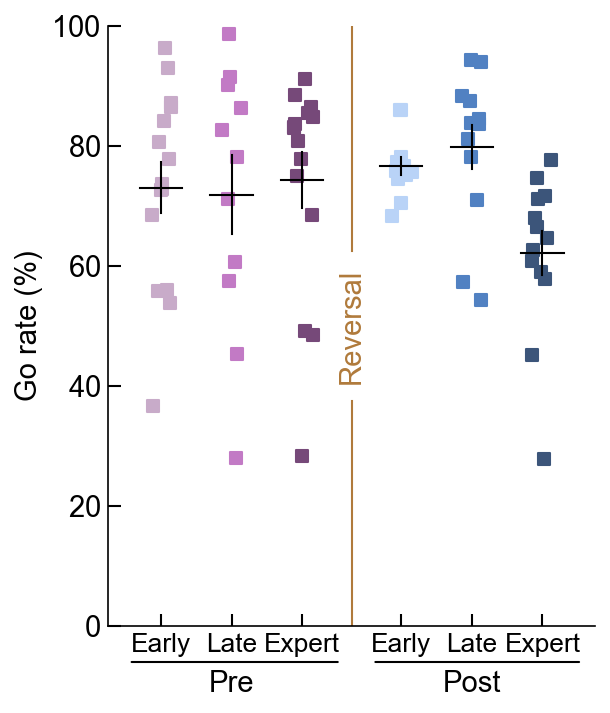

In [54]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
#fig,ax = make_axis_size(2.9, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.2
#switch_offset = 0
################################################################################################################

#Plot figure

data = data_go
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

sz = 35
width = 0.3

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)
    if idx<3:
        ax.scatter(X-switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
        
    else:
        ax.scatter(X+switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx+switch_offset-width,idx+switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx+switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)

    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,100])
ylab = ax.set_ylabel('Go rate (%)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Go response\\go rate_trim.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [64]:
data = SimpleNamespace()
data.preearly = go_preearly_value
data.prelate = go_prelate_value
data.preexpert = go_preexpert_value
data.postearly = go_postearly_value
data.postlate = go_postlate_value
data.postexpert = go_postexpert_value
ilep.nonparametricIndependentStatsCompareToPrevious(data,parametric=True)
pass

            Source            SS    DF          MS         F     p-unc  \
0            phase    774.174152   3.0  258.058051  0.997745  0.397552   
1          context    278.634911   1.0  278.634911  1.077303  0.301993   
2  phase * context   1790.545216   3.0  596.848405  2.307631  0.081635   
3         Residual  24053.628039  93.0  258.641162       NaN       NaN   

        np2  
0  0.031182  
1  0.011451  
2  0.069282  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.002581  0.010324  1.307367
8     post-late  baseline  experimental  0.433956  0.867913 -0.314163
9    pre-expert  baseline  experimental  0.763349  0.879989 -0.120893
10     pre-late  baseline  experimental  0.879989  0.879989  0.061491
key preearly has 15 non-nan elements
key prelate has 11 non-nan elements
key preexpert has 15 non-nan elements
key postearly has 12 non-nan elements
key postlate has 12 non-nan elements
key postexpert has 13 

In [65]:
data = SimpleNamespace()
data.preearly = go_preearly_value
data.prelate = go_prelate_value
data.preexpert = go_preexpert_value
data.postearly = go_postearly_value
data.postlate = go_postlate_value
data.postexpert = go_postexpert_value
ilep.nonparametricIndependentStatsCompareToOwnEarly(data,parametric=True)
pass

            Source            SS    DF          MS         F     p-unc  \
0            phase   1046.881316   3.0  348.960439  1.568589  0.201946   
1          context    185.376728   1.0  185.376728  0.833275  0.363591   
2  phase * context   1213.141145   3.0  404.380382  1.817704  0.149011   
3         Residual  21579.369621  97.0  222.467728       NaN       NaN   

        np2  
0  0.046268  
1  0.008517  
2  0.053225  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.002189  0.008757  1.370843
8     post-late  baseline  experimental  0.433956  0.867913 -0.314163
9    pre-expert  baseline  experimental  0.843184  0.879989 -0.070938
10     pre-late  baseline  experimental  0.879989  0.879989  0.061491
key preearly has 15 non-nan elements
key prelate has 11 non-nan elements
key preexpert has 15 non-nan elements
key postearly has 12 non-nan elements
key postlate has 12 non-nan elements
key postexpert has 13 

### New Figs for HIT/FA rate (Dec 2023)

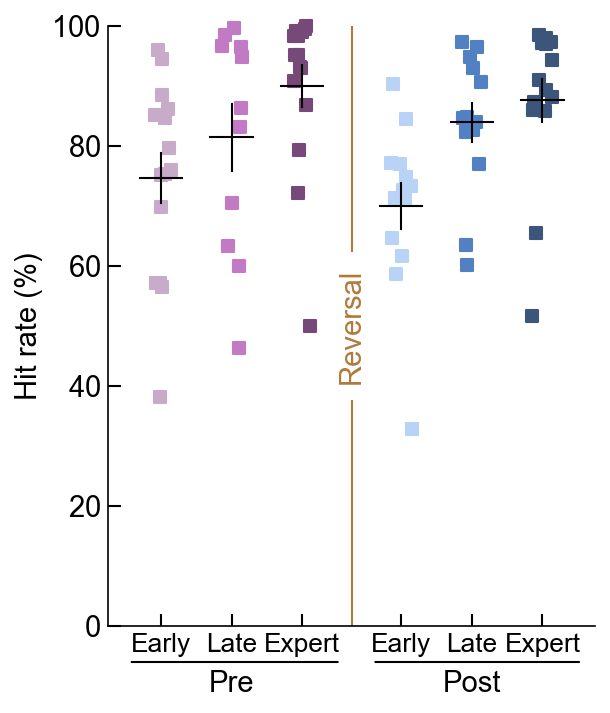

In [42]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
#fig,ax = make_axis_size(2.9, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.2
#switch_offset = 0
################################################################################################################

#Plot figure

data = data_hit
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

sz = 35
width = 0.3

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)
    if idx<3:
        ax.scatter(X-switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s',clip_on=False)
        ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
        
    else:
        ax.scatter(X+switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s',clip_on=False)
        ax.plot([idx+switch_offset-width,idx+switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx+switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)

    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,100])
ylab = ax.set_ylabel('Hit rate (%)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\hit rate_trim.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

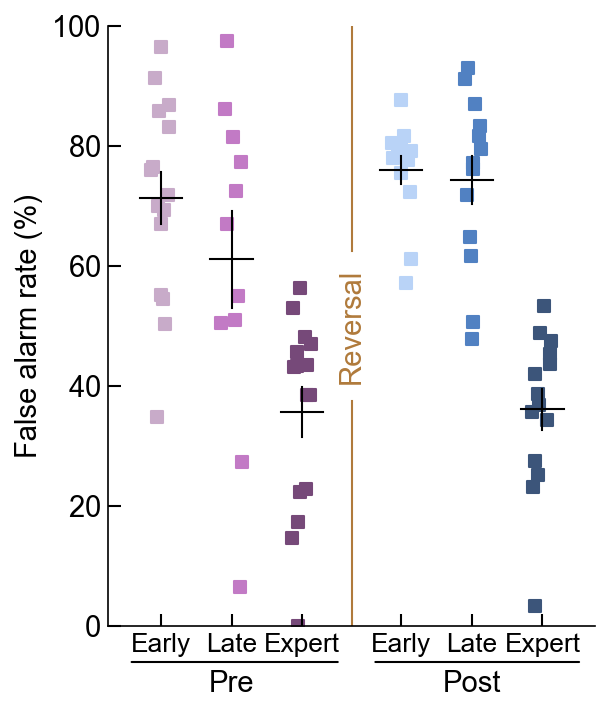

In [43]:
fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.2
#switch_offset = 0
################################################################################################################

#Plot figure

data = data_fa
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

sz = 35
width = 0.3

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)
    if idx<3:
        ax.scatter(X-switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
        
    else:
        ax.scatter(X+switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx+switch_offset-width,idx+switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx+switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)

    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,100])
ylab = ax.set_ylabel('False alarm rate (%)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\FA rate_trim.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

### New Stats for HIT/FA rate

In [44]:
data_hit = SimpleNamespace()
data_hit.preearly = hit_preearly_value
data_hit.prelate = hit_prelate_value
data_hit.preexpert = hit_preexpert_value
data_hit.postearly = hit_postearly_value
data_hit.postlate = hit_postlate_value
data_hit.postexpert = hit_postexpert_value
ilep.ttestindcompareall(data_hit)

pre-early   n = 15
pre-late    n = 11
pre-expert  n = 15
post-early  n = 13
post-late   n = 13
post-expert n = 14
pre-early  to pre-late   : 0.39985423894585403
pre-late   to pre-expert : 0.27881071089663856
pre-early  to pre-expert : 0.022025251729909403
post-early to post-late  : 0.022025251729909403
post-late  to post-expert: 0.45500269981775
post-early to post-expert: 0.01621248282739299


In [45]:
data_fa = SimpleNamespace()
data_fa.preearly = fa_preearly_value
data_fa.prelate = fa_prelate_value
data_fa.preexpert = fa_preexpert_value
data_fa.postearly = fa_postearly_value
data_fa.postlate = fa_postlate_value
data_fa.postexpert = fa_postexpert_value
ilep.ttestindcompareall(data_fa)

pre-early   n = 15
pre-late    n = 11
pre-expert  n = 15
post-early  n = 13
post-late   n = 13
post-expert n = 14
pre-early  to pre-late   : 0.2974234156992714
pre-late   to pre-expert : 0.008932631250686012
pre-early  to pre-expert : 5.030111166172247e-06
post-early to post-late  : 0.7151615659158199
post-late  to post-expert: 4.1757617086729333e-07
post-early to post-expert: 6.596620090239277e-09


In [81]:
data_hit = SimpleNamespace()
data_hit.preearly = hit_preearly_value
data_hit.prelate = hit_prelate_value
data_hit.preexpert = hit_preexpert_value
data_hit.postearly = hit_postearly_value
data_hit.postlate = hit_postlate_value
data_hit.postexpert = hit_postexpert_value
ilep.nonparametricIndependentStatsCompareToPrevious(data_hit,parametric=True)
pass

            Source            SS    DF           MS         F     p-unc  \
0            phase   1234.636744   3.0   411.545581  1.986035  0.121452   
1          context   1185.238023   1.0  1185.238023  5.719717  0.018788   
2  phase * context    196.512727   3.0    65.504242  0.316110  0.813693   
3         Residual  19271.433111  93.0   207.219711       NaN       NaN   

        np2  
0  0.060208  
1  0.057939  
2  0.010094  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.641301  0.641301 -0.181991
8     post-late  baseline  experimental  0.027007  0.108029 -0.933981
9    pre-expert  baseline  experimental  0.207510  0.415020 -0.527313
10     pre-late  baseline  experimental  0.344911  0.459881 -0.379647
key preearly has 15 non-nan elements
key prelate has 11 non-nan elements
key preexpert has 15 non-nan elements
key postearly has 12 non-nan elements
key postlate has 12 non-nan elements
key postexpert ha

In [28]:
data_hit = SimpleNamespace()
data_hit.preearly = hit_preearly_value
data_hit.prelate = hit_prelate_value
data_hit.preexpert = hit_preexpert_value
data_hit.postearly = hit_postearly_value
data_hit.postlate = hit_postlate_value
data_hit.postexpert = hit_postexpert_value
ilep.nonparametricIndependentStatsCompareToOwnEarly(data_hit,parametric=True)
pass

            Source            SS    DF           MS          F     p-unc  \
0            phase    376.051179   3.0   125.350393   0.557144  0.644589   
1          context   4347.026881   1.0  4347.026881  19.321211  0.000028   
2  phase * context    345.230027   3.0   115.076676   0.511481  0.675310   
3         Residual  21823.767213  97.0   224.987291        NaN       NaN   

        np2  
0  0.016939  
1  0.166102  
2  0.015573  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.009154  0.018308 -1.104822
8     post-late  baseline  experimental  0.023985  0.031979 -0.955750
9    pre-expert  baseline  experimental  0.009021  0.018308 -0.996963
10     pre-late  baseline  experimental  0.344911  0.344911 -0.379647
key preearly has 15 non-nan elements
key prelate has 11 non-nan elements
key preexpert has 15 non-nan elements
key postearly has 12 non-nan elements
key postlate has 12 non-nan elements
key postexpe

In [29]:
ilep.nonparametricIndependentStatsCompareToPrevious(data_hit,parametric=True)
pass

            Source            SS    DF           MS         F     p-unc  \
0            phase   1524.258633   3.0   508.086211  2.257084  0.086909   
1          context   1514.136395   1.0  1514.136395  6.726285  0.011036   
2  phase * context    331.946384   3.0   110.648795  0.491538  0.689011   
3         Residual  20934.986265  93.0   225.107379       NaN       NaN   

        np2  
0  0.067868  
1  0.067447  
2  0.015609  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.585146  0.585146 -0.213258
8     post-late  baseline  experimental  0.023985  0.095938 -0.955750
9    pre-expert  baseline  experimental  0.207510  0.415020 -0.527313
10     pre-late  baseline  experimental  0.344911  0.459881 -0.379647
key preearly has 15 non-nan elements
key prelate has 11 non-nan elements
key preexpert has 15 non-nan elements
key postearly has 12 non-nan elements
key postlate has 12 non-nan elements
key postexpert ha

In [21]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

In [25]:
data_fa = SimpleNamespace()
data_fa.preearly = fa_preearly_value
data_fa.prelate = fa_prelate_value
data_fa.preexpert = fa_preexpert_value
data_fa.postearly = fa_postearly_value
data_fa.postlate = fa_postlate_value
data_fa.postexpert = fa_postexpert_value
ilep.nonparametricIndependentStatsCompareToPrevious(data_fa,parametric=True)
pass


            Source            SS    DF           MS          F     p-unc  \
0            phase   6773.312906   3.0  2257.770969   6.185825  0.000704   
1          context   5311.184360   1.0  5311.184360  14.551546  0.000245   
2  phase * context   5227.434035   3.0  1742.478012   4.774029  0.003862   
3         Residual  33944.170467  93.0   364.991080        NaN       NaN   

        np2  
0  0.166349  
1  0.135298  
2  0.133450  
3       NaN  

          phase         A             B         p-unc    p-corr    hedges
7   post-expert  baseline  experimental  4.427429e-07  0.000002  2.714112
8     post-late  baseline  experimental  3.674447e-01  0.489926  0.362719
9    pre-expert  baseline  experimental  6.467384e-01  0.646738  0.180957
10     pre-late  baseline  experimental  2.855751e-01  0.489926  0.455309
key preearly has 15 non-nan elements
key prelate has 11 non-nan elements
key preexpert has 15 non-nan elements
key postearly has 12 non-nan elements
key postlate has 12 non-nan e

In [30]:
data_fa = SimpleNamespace()
data_fa.preearly = fa_preearly_value
data_fa.prelate = fa_prelate_value
data_fa.preexpert = fa_preexpert_value
data_fa.postearly = fa_postearly_value
data_fa.postlate = fa_postlate_value
data_fa.postexpert = fa_postexpert_value
ilep.nonparametricIndependentStatsCompareToOwnEarly(data_fa,parametric=True)
pass

            Source            SS    DF            MS          F         p-unc  \
0            phase   8234.710223   3.0   2744.903408  10.944052  2.964415e-06   
1          context  14013.606493   1.0  14013.606493  55.872873  3.444204e-11   
2  phase * context   6999.999421   3.0   2333.333140   9.303103  1.825330e-05   
3         Residual  24328.797744  97.0    250.812348        NaN           NaN   

        np2  
0  0.252882  
1  0.365486  
2  0.223437  
3       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  1.384991e-08  5.539965e-08  3.760686
8     post-late  baseline  experimental  6.311903e-01  6.311903e-01  0.191896
9    pre-expert  baseline  experimental  2.700882e-06  5.401763e-06  2.080376
10     pre-late  baseline  experimental  2.855751e-01  3.807668e-01  0.455309
key preearly has 15 non-nan elements
key prelate has 11 non-nan elements
key preexpert has 15 non-nan elements
key postearly has 12 n

In [31]:
ilep.nonparametricIndependentStatsCompareToPrevious(data_fa,parametric=True)
pass

            Source            SS    DF           MS          F         p-unc  \
0            phase  11456.458441   3.0  3818.819480  12.095583  9.380632e-07   
1          context   9445.814805   1.0  9445.814805  29.918312  3.779509e-07   
2  phase * context   5054.284877   3.0  1684.761626   5.336249  1.950275e-03   
3         Residual  29361.976272  93.0   315.720175        NaN           NaN   

        np2  
0  0.280669  
1  0.243400  
2  0.146857  
3       NaN  

          phase         A             B         p-unc    p-corr    hedges
7   post-expert  baseline  experimental  4.302302e-07  0.000002  2.722973
8     post-late  baseline  experimental  6.311903e-01  0.631190  0.191896
9    pre-expert  baseline  experimental  1.348633e-02  0.026973  1.154632
10     pre-late  baseline  experimental  2.855751e-01  0.380767  0.455309
key preearly has 15 non-nan elements
key prelate has 11 non-nan elements
key preexpert has 15 non-nan elements
key postearly has 12 non-nan elements
key postl

In [32]:
 3.807668e-01

0.3807668

In [2]:
1.286601e-01

0.1286601

In [3]:
3.674447e-01

0.3674447

In [38]:
1.206492e-07

1.206492e-07

In [39]:
3.674447e-01 

0.3674447

In [47]:
0.000002  < 0.0001

True

In [41]:
3.674447e-01

0.3674447

### Old Hit rate and False alarm rate (NOT USED)

In [9]:
def get_animal_session_outcomes(animal,session_num):
    print(animal)
    print(session_num)
    session_trials = np.array(animalBehaviors[animal].sessions[session_num].outcomes)
    print('session trials:' + str(len(session_trials)))

    session_hit_trials = []
    session_miss_trials = []
    
    session_fa_trials = []
    session_cr_trials = []

    for idx, outcome in enumerate(session_trials):
        if outcome == 1:
            session_hit_trials.append(idx)
        if outcome == 2:
            session_miss_trials.append(idx)
        if outcome == 3:
            session_fa_trials.append(idx)
        if outcome == 4:
            session_cr_trials.append(idx)

    session_hit = len(session_hit_trials)
    session_miss = len(session_miss_trials)
    session_fa = len(session_fa_trials)
    session_cr = len(session_cr_trials)
    
    return session_hit,session_miss,session_fa,session_cr

In [10]:
get_animal_session_outcomes('BS_108',1)[0]

BS_108
1
session trials:398


180

In [11]:
get_animal_session_outcomes('BS_108',2)[0]

BS_108
2
session trials:413


176

In [12]:
get_animal_session_outcomes('BS_108',3)[0]

BS_108
3
session trials:410


206

In [13]:
BS_108_hit = 0
BS_108_miss = 0
for i in range(1,len(animalBehaviors['BS_108'].sessions)+1):
    if i in learning_phases['BS_108'].pre_early_days:
        hit = get_animal_session_outcomes('BS_108',i)[0]
        BS_108_hit = BS_108_hit + hit
        miss = get_animal_session_outcomes('BS_108',i)[1]
        BS_108_miss = BS_108_miss + miss
    

BS_108
1
session trials:398
BS_108
1
session trials:398
BS_108
2
session trials:413
BS_108
2
session trials:413
BS_108
3
session trials:410
BS_108
3
session trials:410


In [14]:
hit_preearly = dict()
hit_prelate = dict()
hit_preexpert = dict()
hit_postearly = dict()
hit_postlate = dict()
hit_postexpert = dict()

fa_preearly = dict()
fa_prelate = dict()
fa_preexpert = dict()
fa_postearly = dict()
fa_postlate = dict()
fa_postexpert = dict()

for animal in animals:
    hit_preearly[animal] = []
    hit_prelate[animal] = []
    hit_preexpert[animal] = []
    hit_postearly[animal] = []
    hit_postlate[animal] = []
    hit_postexpert[animal] = []
    
    fa_preearly[animal] = []
    fa_prelate[animal] = []
    fa_preexpert[animal] = []
    fa_postearly[animal] = []
    fa_postlate[animal] = []
    fa_postexpert[animal] = []

In [15]:
for animal in animals:
    #DS_19 miss reaction time data since session11 so I will only include sessions before that
    if animal == 'DS_19':
        continue
        
    try:   
        animal_preearly = np.zeros(4)
        animal_prelate = np.zeros(4)
        animal_preexpert = np.zeros(4) 

        for i in range(1,len(animalBehaviors[animal].sessions)+1):
            if i in learning_phases[animal].pre_early_days:
                hit = get_animal_session_outcomes(animal,i)[0]
                animal_preearly[0] = animal_preearly[0] + hit
                miss = get_animal_session_outcomes(animal,i)[1]
                animal_preearly[1] = animal_preearly[1] + miss
                fa = get_animal_session_outcomes(animal,i)[2]
                animal_preearly[2] = animal_preearly[2] + fa
                cr = get_animal_session_outcomes(animal,i)[3]
                animal_preearly[3] = animal_preearly[3] + cr
            
            if i in learning_phases[animal].pre_late_days:
                hit = get_animal_session_outcomes(animal,i)[0]
                animal_prelate[0] = animal_prelate[0] + hit
                miss = get_animal_session_outcomes(animal,i)[1]
                animal_prelate[1] = animal_prelate[1] + miss
                fa = get_animal_session_outcomes(animal,i)[2]
                animal_prelate[2] = animal_prelate[2] + fa
                cr = get_animal_session_outcomes(animal,i)[3]
                animal_prelate[3] = animal_prelate[3] + cr
                
            if i in learning_phases[animal].pre_expert_days:
                hit = get_animal_session_outcomes(animal,i)[0]
                animal_preexpert[0] = animal_preexpert[0] + hit
                miss = get_animal_session_outcomes(animal,i)[1]
                animal_preexpert[1] = animal_preexpert[1] + miss
                fa = get_animal_session_outcomes(animal,i)[2]
                animal_preexpert[2] = animal_preexpert[2] + fa
                cr = get_animal_session_outcomes(animal,i)[3]
                animal_preexpert[3] = animal_preexpert[3] + cr
                

        animal_hitrate_preearly = animal_preearly[0] / (animal_preearly[0] + animal_preearly[1])*100
        animal_farate_preearly = animal_preearly[2] / (animal_preearly[2] + animal_preearly[3])*100
        hit_preearly[animal] = animal_hitrate_preearly
        fa_preearly[animal] = animal_farate_preearly

        animal_hitrate_prelate = animal_prelate[0] / (animal_prelate[0] + animal_prelate[1])*100
        animal_farate_prelate = animal_prelate[2] / (animal_prelate[2] + animal_prelate[3])*100
        hit_prelate[animal] = animal_hitrate_prelate
        fa_prelate[animal] = animal_farate_prelate
        
        animal_hitrate_preexpert = animal_preexpert[0] / (animal_preexpert[0] + animal_preexpert[1])*100
        animal_farate_preexpert = animal_preexpert[2] / (animal_preexpert[2] + animal_preexpert[3])*100
        hit_preexpert[animal] = animal_hitrate_preexpert
        fa_preexpert[animal] = animal_farate_preexpert

        
    except Exception as e:
        print('e')
        print(animal)
        print(i)

BS_40
1
session trials:374
BS_40
1
session trials:374
BS_40
1
session trials:374
BS_40
1
session trials:374
BS_40
2
session trials:370
BS_40
2
session trials:370
BS_40
2
session trials:370
BS_40
2
session trials:370
BS_40
3
session trials:452
BS_40
3
session trials:452
BS_40
3
session trials:452
BS_40
3
session trials:452
BS_40
4
session trials:445
BS_40
4
session trials:445
BS_40
4
session trials:445
BS_40
4
session trials:445
BS_40
5
session trials:200
BS_40
5
session trials:200
BS_40
5
session trials:200
BS_40
5
session trials:200
BS_40
6
session trials:392
BS_40
6
session trials:392
BS_40
6
session trials:392
BS_40
6
session trials:392
BS_40
7
session trials:438
BS_40
7
session trials:438
BS_40
7
session trials:438
BS_40
7
session trials:438
BS_40
8
session trials:500
BS_40
8
session trials:500
BS_40
8
session trials:500
BS_40
8
session trials:500
BS_40
9
session trials:504
BS_40
9
session trials:504
BS_40
9
session trials:504
BS_40
9
session trials:504
BS_40
10
session trials:600


C:\Users\insan\AppData\Local\Temp\ipykernel_12148\3771652569.py:48: RuntimeWarning: invalid value encountered in double_scalars
  animal_hitrate_prelate = animal_prelate[0] / (animal_prelate[0] + animal_prelate[1])*100
C:\Users\insan\AppData\Local\Temp\ipykernel_12148\3771652569.py:49: RuntimeWarning: invalid value encountered in double_scalars
  animal_farate_prelate = animal_prelate[2] / (animal_prelate[2] + animal_prelate[3])*100


In [16]:
for animal in animals:
    #DS_19 miss reaction time data since session11 so I will only include sessions before that
    if animal == 'DS_19':
        continue
        
    try:   
        animal_postearly = np.zeros(4)
        animal_postlate = np.zeros(4)
        animal_postexpert = np.zeros(4)      

        for i in range(1,len(animalBehaviors[animal].sessions)+1):
            if i in learning_phases[animal].post_early_days:
                hit = get_animal_session_outcomes(animal,i)[0]
                animal_postearly[0] = animal_postearly[0] + hit
                miss = get_animal_session_outcomes(animal,i)[1]
                animal_postearly[1] = animal_postearly[1] + miss
                fa = get_animal_session_outcomes(animal,i)[2]
                animal_postearly[2] = animal_postearly[2] + fa
                cr = get_animal_session_outcomes(animal,i)[3]
                animal_postearly[3] = animal_postearly[3] + cr
            
            if i in learning_phases[animal].post_late_days:
                hit = get_animal_session_outcomes(animal,i)[0]
                animal_postlate[0] = animal_postlate[0] + hit
                miss = get_animal_session_outcomes(animal,i)[1]
                animal_postlate[1] = animal_postlate[1] + miss
                fa = get_animal_session_outcomes(animal,i)[2]
                animal_postlate[2] = animal_postlate[2] + fa
                cr = get_animal_session_outcomes(animal,i)[3]
                animal_postlate[3] = animal_postlate[3] + cr
                
            if i in learning_phases[animal].post_expert_days:
                hit = get_animal_session_outcomes(animal,i)[0]
                animal_postexpert[0] = animal_postexpert[0] + hit
                miss = get_animal_session_outcomes(animal,i)[1]
                animal_postexpert[1] = animal_postexpert[1] + miss
                fa = get_animal_session_outcomes(animal,i)[2]
                animal_postexpert[2] = animal_postexpert[2] + fa
                cr = get_animal_session_outcomes(animal,i)[3]
                animal_postexpert[3] = animal_postexpert[3] + cr
                

        animal_hitrate_postearly = animal_postearly[0] / (animal_postearly[0] + animal_postearly[1])*100
        animal_farate_postearly = animal_postearly[2] / (animal_postearly[2] + animal_postearly[3])*100
        hit_postearly[animal] = animal_hitrate_postearly
        fa_postearly[animal] = animal_farate_postearly

        animal_hitrate_postlate = animal_postlate[0] / (animal_postlate[0] + animal_postlate[1])*100
        animal_farate_postlate = animal_postlate[2] / (animal_postlate[2] + animal_postlate[3])*100
        hit_postlate[animal] = animal_hitrate_postlate
        fa_postlate[animal] = animal_farate_postlate
        
        animal_hitrate_postexpert = animal_postexpert[0] / (animal_postexpert[0] + animal_postexpert[1])*100
        animal_farate_postexpert = animal_postexpert[2] / (animal_postexpert[2] + animal_postexpert[3])*100
        hit_postexpert[animal] = animal_hitrate_postexpert
        fa_postexpert[animal] = animal_farate_postexpert

        
    except Exception as e:
        print('e')
        print(animal)
        print(i)

BS_40
19
session trials:300
BS_40
19
session trials:300
BS_40
19
session trials:300
BS_40
19
session trials:300
BS_40
20
session trials:300
BS_40
20
session trials:300
BS_40
20
session trials:300
BS_40
20
session trials:300
BS_40
21
session trials:307
BS_40
21
session trials:307
BS_40
21
session trials:307
BS_40
21
session trials:307
BS_40
22
session trials:300
BS_40
22
session trials:300
BS_40
22
session trials:300
BS_40
22
session trials:300
BS_40
23
session trials:344
BS_40
23
session trials:344
BS_40
23
session trials:344
BS_40
23
session trials:344
BS_40
24
session trials:391
BS_40
24
session trials:391
BS_40
24
session trials:391
BS_40
24
session trials:391
BS_40
25
session trials:340
BS_40
25
session trials:340
BS_40
25
session trials:340
BS_40
25
session trials:340
BS_40
26
session trials:544
BS_40
26
session trials:544
BS_40
26
session trials:544
BS_40
26
session trials:544
BS_40
27
session trials:400
BS_40
27
session trials:400
BS_40
27
session trials:400
BS_40
27
session tri

C:\Users\insan\AppData\Local\Temp\ipykernel_12148\3477972177.py:43: RuntimeWarning: invalid value encountered in double_scalars
  animal_hitrate_postearly = animal_postearly[0] / (animal_postearly[0] + animal_postearly[1])*100
C:\Users\insan\AppData\Local\Temp\ipykernel_12148\3477972177.py:44: RuntimeWarning: invalid value encountered in double_scalars
  animal_farate_postearly = animal_postearly[2] / (animal_postearly[2] + animal_postearly[3])*100
C:\Users\insan\AppData\Local\Temp\ipykernel_12148\3477972177.py:48: RuntimeWarning: invalid value encountered in double_scalars
  animal_hitrate_postlate = animal_postlate[0] / (animal_postlate[0] + animal_postlate[1])*100
C:\Users\insan\AppData\Local\Temp\ipykernel_12148\3477972177.py:49: RuntimeWarning: invalid value encountered in double_scalars
  animal_farate_postlate = animal_postlate[2] / (animal_postlate[2] + animal_postlate[3])*100
C:\Users\insan\AppData\Local\Temp\ipykernel_12148\3477972177.py:53: RuntimeWarning: invalid value enco

BS_70
16
session trials:384
BS_70
17
session trials:483
BS_70
17
session trials:483
BS_70
17
session trials:483
BS_70
17
session trials:483
BS_70
18
session trials:656
BS_70
18
session trials:656
BS_70
18
session trials:656
BS_70
18
session trials:656
BS_72
7
session trials:392
BS_72
7
session trials:392
BS_72
7
session trials:392
BS_72
7
session trials:392
BS_72
8
session trials:500
BS_72
8
session trials:500
BS_72
8
session trials:500
BS_72
8
session trials:500
BS_72
9
session trials:500
BS_72
9
session trials:500
BS_72
9
session trials:500
BS_72
9
session trials:500
BS_72
10
session trials:366
BS_72
10
session trials:366
BS_72
10
session trials:366
BS_72
10
session trials:366
BS_72
11
session trials:381
BS_72
11
session trials:381
BS_72
11
session trials:381
BS_72
11
session trials:381
BS_72
12
session trials:203
BS_72
12
session trials:203
BS_72
12
session trials:203
BS_72
12
session trials:203
BS_72
13
session trials:276
BS_72
13
session trials:276
BS_72
13
session trials:276
BS_7

In [17]:
hit_preearly

{'BS_40': 60.37735849056604,
 'BS_41': 84.90566037735849,
 'BS_42': 79.21847246891652,
 'BS_49': 45.806451612903224,
 'BS_50': 68.82453151618398,
 'BS_51': 79.47320617620345,
 'BS_56': 55.65529622980251,
 'BS_59': 74.5958429561201,
 'BS_67': 94.70827679782904,
 'BS_70': 96.66048237476808,
 'BS_72': 84.73154362416108,
 'BS_87': 57.14285714285714,
 'BS_108': 88.50393700787401,
 'DS_15': 74.56828885400314,
 'DS_19': []}

In [18]:
animal = 'DS_19'

animal_preearly = np.zeros(4)
animal_prelate = np.zeros(4)
animal_preexpert = np.zeros(4) 

for i in range(1,11):
    if i in learning_phases[animal].pre_early_days:
        hit = get_animal_session_outcomes(animal,i)[0]
        animal_preearly[0] = animal_preearly[0] + hit
        miss = get_animal_session_outcomes(animal,i)[1]
        animal_preearly[1] = animal_preearly[1] + miss
        fa = get_animal_session_outcomes(animal,i)[2]
        animal_preearly[2] = animal_preearly[2] + fa
        cr = get_animal_session_outcomes(animal,i)[3]
        animal_preearly[3] = animal_preearly[3] + cr

    if i in learning_phases[animal].pre_late_days:
        hit = get_animal_session_outcomes(animal,i)[0]
        animal_prelate[0] = animal_prelate[0] + hit
        miss = get_animal_session_outcomes(animal,i)[1]
        animal_prelate[1] = animal_prelate[1] + miss
        fa = get_animal_session_outcomes(animal,i)[2]
        animal_prelate[2] = animal_prelate[2] + fa
        cr = get_animal_session_outcomes(animal,i)[3]
        animal_prelate[3] = animal_prelate[3] + cr

    if i in learning_phases[animal].pre_expert_days:
        hit = get_animal_session_outcomes(animal,i)[0]
        animal_preexpert[0] = animal_preexpert[0] + hit
        miss = get_animal_session_outcomes(animal,i)[1]
        animal_preexpert[1] = animal_preexpert[1] + miss
        fa = get_animal_session_outcomes(animal,i)[2]
        animal_preexpert[2] = animal_preexpert[2] + fa
        cr = get_animal_session_outcomes(animal,i)[3]
        animal_preexpert[3] = animal_preexpert[3] + cr


animal_hitrate_preearly = animal_preearly[0] / (animal_preearly[0] + animal_preearly[1])*100
animal_farate_preearly = animal_preearly[2] / (animal_preearly[2] + animal_preearly[3])*100
hit_preearly[animal] = animal_hitrate_preearly
fa_preearly[animal] = animal_farate_preearly

animal_hitrate_prelate = animal_prelate[0] / (animal_prelate[0] + animal_prelate[1])*100
animal_farate_prelate = animal_prelate[2] / (animal_prelate[2] + animal_prelate[3])*100
hit_prelate[animal] = animal_hitrate_prelate
fa_prelate[animal] = animal_farate_prelate

animal_hitrate_preexpert = animal_preexpert[0] / (animal_preexpert[0] + animal_preexpert[1])*100
animal_farate_preexpert = animal_preexpert[2] / (animal_preexpert[2] + animal_preexpert[3])*100
hit_preexpert[animal] = animal_hitrate_preexpert
fa_preexpert[animal] = animal_farate_preexpert

DS_19
1
session trials:400
DS_19
1
session trials:400
DS_19
1
session trials:400
DS_19
1
session trials:400
DS_19
2
session trials:463
DS_19
2
session trials:463
DS_19
2
session trials:463
DS_19
2
session trials:463
DS_19
3
session trials:500
DS_19
3
session trials:500
DS_19
3
session trials:500
DS_19
3
session trials:500
DS_19
4
session trials:500
DS_19
4
session trials:500
DS_19
4
session trials:500
DS_19
4
session trials:500
DS_19
5
session trials:500
DS_19
5
session trials:500
DS_19
5
session trials:500
DS_19
5
session trials:500
DS_19
6
session trials:600
DS_19
6
session trials:600
DS_19
6
session trials:600
DS_19
6
session trials:600
DS_19
7
session trials:300
DS_19
7
session trials:300
DS_19
7
session trials:300
DS_19
7
session trials:300
DS_19
8
session trials:400
DS_19
8
session trials:400
DS_19
8
session trials:400
DS_19
8
session trials:400
DS_19
9
session trials:400
DS_19
9
session trials:400
DS_19
9
session trials:400
DS_19
9
session trials:400
DS_19
10
session trials:400


In [19]:
animal = 'DS_19'

animal_postearly = np.zeros(4)
animal_postlate = np.zeros(4)
animal_postexpert = np.zeros(4)      

for i in range(1,11):
    if i in learning_phases[animal].post_early_days:
        hit = get_animal_session_outcomes(animal,i)[0]
        animal_postearly[0] = animal_postearly[0] + hit
        miss = get_animal_session_outcomes(animal,i)[1]
        animal_postearly[1] = animal_postearly[1] + miss
        fa = get_animal_session_outcomes(animal,i)[2]
        animal_postearly[2] = animal_postearly[2] + fa
        cr = get_animal_session_outcomes(animal,i)[3]
        animal_postearly[3] = animal_postearly[3] + cr

    if i in learning_phases[animal].post_late_days:
        hit = get_animal_session_outcomes(animal,i)[0]
        animal_postlate[0] = animal_postlate[0] + hit
        miss = get_animal_session_outcomes(animal,i)[1]
        animal_postlate[1] = animal_postlate[1] + miss
        fa = get_animal_session_outcomes(animal,i)[2]
        animal_postlate[2] = animal_postlate[2] + fa
        cr = get_animal_session_outcomes(animal,i)[3]
        animal_postlate[3] = animal_postlate[3] + cr

    if i in learning_phases[animal].post_expert_days:
        hit = get_animal_session_outcomes(animal,i)[0]
        animal_postexpert[0] = animal_postexpert[0] + hit
        miss = get_animal_session_outcomes(animal,i)[1]
        animal_postexpert[1] = animal_postexpert[1] + miss
        fa = get_animal_session_outcomes(animal,i)[2]
        animal_postexpert[2] = animal_postexpert[2] + fa
        cr = get_animal_session_outcomes(animal,i)[3]
        animal_postexpert[3] = animal_postexpert[3] + cr


animal_hitrate_postearly = animal_postearly[0] / (animal_postearly[0] + animal_postearly[1])*100
animal_farate_postearly = animal_postearly[2] / (animal_postearly[2] + animal_postearly[3])*100
hit_postearly[animal] = animal_hitrate_postearly
fa_postearly[animal] = animal_farate_postearly

animal_hitrate_postlate = animal_postlate[0] / (animal_postlate[0] + animal_postlate[1])*100
animal_farate_postlate = animal_postlate[2] / (animal_postlate[2] + animal_postlate[3])*100
hit_postlate[animal] = animal_hitrate_postlate
fa_postlate[animal] = animal_farate_postlate

animal_hitrate_postexpert = animal_postexpert[0] / (animal_postexpert[0] + animal_postexpert[1])*100
animal_farate_postexpert = animal_postexpert[2] / (animal_postexpert[2] + animal_postexpert[3])*100
hit_postexpert[animal] = animal_hitrate_postexpert
fa_postexpert[animal] = animal_farate_postexpert

C:\Users\insan\AppData\Local\Temp\ipykernel_12148\2311203761.py:39: RuntimeWarning: invalid value encountered in double_scalars
  animal_hitrate_postearly = animal_postearly[0] / (animal_postearly[0] + animal_postearly[1])*100
C:\Users\insan\AppData\Local\Temp\ipykernel_12148\2311203761.py:40: RuntimeWarning: invalid value encountered in double_scalars
  animal_farate_postearly = animal_postearly[2] / (animal_postearly[2] + animal_postearly[3])*100
C:\Users\insan\AppData\Local\Temp\ipykernel_12148\2311203761.py:44: RuntimeWarning: invalid value encountered in double_scalars
  animal_hitrate_postlate = animal_postlate[0] / (animal_postlate[0] + animal_postlate[1])*100
C:\Users\insan\AppData\Local\Temp\ipykernel_12148\2311203761.py:45: RuntimeWarning: invalid value encountered in double_scalars
  animal_farate_postlate = animal_postlate[2] / (animal_postlate[2] + animal_postlate[3])*100
C:\Users\insan\AppData\Local\Temp\ipykernel_12148\2311203761.py:49: RuntimeWarning: invalid value enco

In [20]:
hit_preearly_value = list(hit_preearly.values())
hit_prelate_value = list(hit_prelate.values())
hit_preexpert_value = list(hit_preexpert.values())
hit_postearly_value = list(hit_postearly.values())
hit_postlate_value = list(hit_postlate.values())
hit_postexpert_value = list(hit_postexpert.values())

fa_preearly_value = list(fa_preearly.values())
fa_prelate_value = list(fa_prelate.values())
fa_preexpert_value = list(fa_preexpert.values())
fa_postearly_value = list(fa_postearly.values())
fa_postlate_value = list(fa_postlate.values())
fa_postexpert_value = list(fa_postexpert.values())

In [21]:
hit_preearly

{'BS_40': 60.37735849056604,
 'BS_41': 84.90566037735849,
 'BS_42': 79.21847246891652,
 'BS_49': 45.806451612903224,
 'BS_50': 68.82453151618398,
 'BS_51': 79.47320617620345,
 'BS_56': 55.65529622980251,
 'BS_59': 74.5958429561201,
 'BS_67': 94.70827679782904,
 'BS_70': 96.66048237476808,
 'BS_72': 84.73154362416108,
 'BS_87': 57.14285714285714,
 'BS_108': 88.50393700787401,
 'DS_15': 74.56828885400314,
 'DS_19': 86.53421633554083}

In [22]:
hit_preearly_value

[60.37735849056604,
 84.90566037735849,
 79.21847246891652,
 45.806451612903224,
 68.82453151618398,
 79.47320617620345,
 55.65529622980251,
 74.5958429561201,
 94.70827679782904,
 96.66048237476808,
 84.73154362416108,
 57.14285714285714,
 88.50393700787401,
 74.56828885400314,
 86.53421633554083]

In [23]:
data_hit = [hit_preearly_value,hit_prelate_value,hit_preexpert_value,hit_postearly_value,hit_postlate_value,hit_postexpert_value]

In [24]:
data_fa = [fa_preearly_value,fa_prelate_value,fa_preexpert_value,fa_postearly_value,fa_postlate_value,fa_postexpert_value]

meta NOT subset; don't know how to subset; dropped


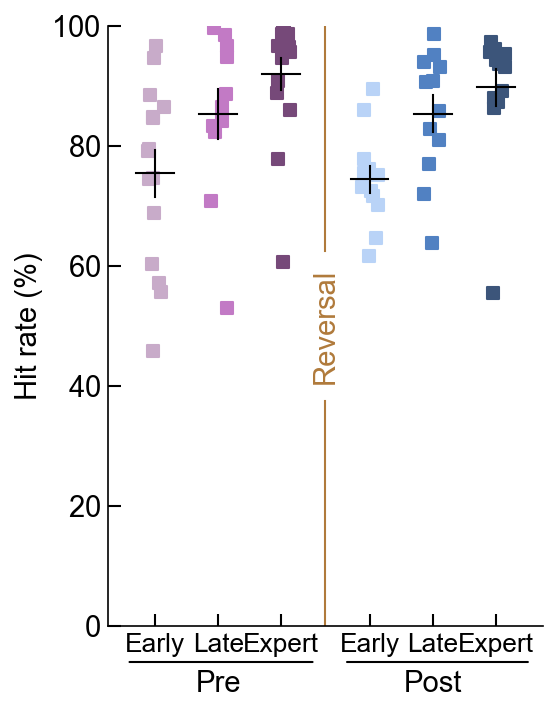

In [25]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(2.9, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.2
#switch_offset = 0
################################################################################################################

#Plot figure

data = data_hit
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

sz = 35
width = 0.3

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)
    if idx<3:
        ax.scatter(X-switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
        
    else:
        ax.scatter(X+switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx+switch_offset-width,idx+switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx+switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)

    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,100])
ylab = ax.set_ylabel('Hit rate (%)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\hit rate.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

meta NOT subset; don't know how to subset; dropped


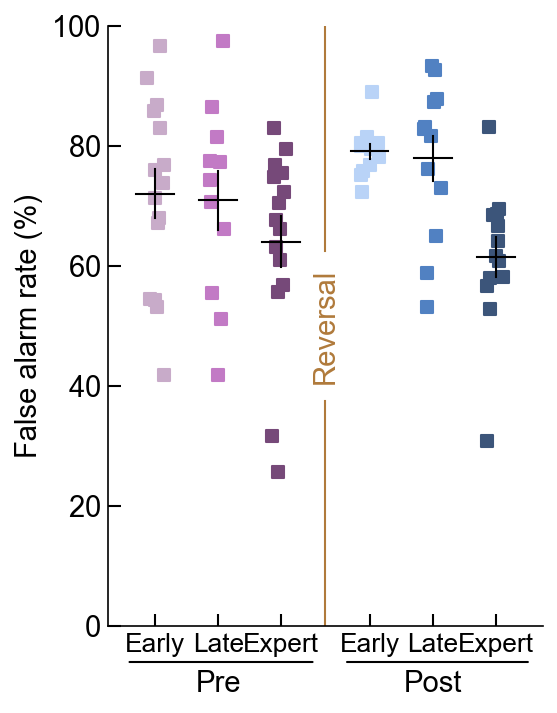

In [26]:
fig,ax = make_axis_size(2.9, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.2
#switch_offset = 0
################################################################################################################

#Plot figure

data = data_fa
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

sz = 35
width = 0.3

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)
    if idx<3:
        ax.scatter(X-switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
        
    else:
        ax.scatter(X+switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx+switch_offset-width,idx+switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx+switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)

    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,100])
ylab = ax.set_ylabel('False alarm rate (%)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\FA rate.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [27]:
data_hit = SimpleNamespace()
data_hit.preearly = hit_preearly_value
data_hit.prelate = hit_prelate_value
data_hit.preexpert = hit_preexpert_value
data_hit.postearly = hit_postearly_value
data_hit.postlate = hit_postlate_value
data_hit.postexpert = hit_postexpert_value
ilep.nonparametricIndependentStatsCompareToPrevious(data_hit)
pass

# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

            Source            SS    DF           MS          F     p-unc  \
0            phase   1599.291779   3.0   533.097260   3.799167  0.012809   
1          context   1569.672918   1.0  1569.672918  11.186418  0.001189   
2  phase * context    165.640752   3.0    55.213584   0.393485  0.757974   
3         Residual  13049.716335  93.0   140.319530        NaN       NaN   

        np2  
0  0.109174  
1  0.107369  
2  0.012534  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.149469  0.149469 -0.395386
8     post-late  baseline  experimental  0.012023  0.048091 -1.141183
9    pre-expert  baseline  experimental  0.119471  0.149469 -0.538829
10     pre-late  baseline  experimental  0.096754  0.149469 -0.657472


In [28]:
ilep.nonparametricIndependentStatsCompareToOwnEarly(data_hit)
pass

            Source            SS    DF           MS          F         p-unc  \
0            phase    230.318257   3.0    76.772752   0.538391  6.571054e-01   
1          context   4633.279111   1.0  4633.279111  32.492222  1.288339e-07   
2  phase * context    212.667261   3.0    70.889087   0.497130  6.851285e-01   
3         Residual  13831.866330  97.0   142.596560        NaN           NaN   

        np2  
0  0.016379  
1  0.250920  
2  0.015142  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.000822  0.001645 -1.543976
8     post-late  baseline  experimental  0.012023  0.016030 -1.141183
9    pre-expert  baseline  experimental  0.000671  0.001645 -1.233639
10     pre-late  baseline  experimental  0.096754  0.096754 -0.657472


In [29]:
data_fa = SimpleNamespace()
data_fa.preearly = fa_preearly_value
data_fa.prelate = fa_prelate_value
data_fa.preexpert = fa_preexpert_value
data_fa.postearly = fa_postearly_value
data_fa.postlate = fa_postlate_value
data_fa.postexpert = fa_postexpert_value
ilep.nonparametricIndependentStatsCompareToPrevious(data_fa)
pass


            Source            SS    DF           MS         F     p-unc  \
0            phase   1708.216174   3.0   569.405391  2.902093  0.039010   
1          context   1032.012858   1.0  1032.012858  5.259868  0.024075   
2  phase * context    970.470426   3.0   323.490142  1.648735  0.183518   
3         Residual  18247.073129  93.0   196.205087       NaN       NaN   

        np2  
0  0.085602  
1  0.053530  
2  0.050499  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.008338  0.033353  1.268737
8     post-late  baseline  experimental  0.544370  0.725827  0.116306
9    pre-expert  baseline  experimental  0.324085  0.648169  0.407000
10     pre-late  baseline  experimental  0.917328  0.917328  0.068345


In [30]:
ilep.nonparametricIndependentStatsCompareToOwnEarly(data_fa)
pass

            Source            SS    DF           MS         F     p-unc  \
0            phase   1591.418235   3.0   530.472745  2.961622  0.036002   
1          context   1299.211010   1.0  1299.211010  7.253478  0.008338   
2  phase * context   1131.964195   3.0   377.321398  2.106580  0.104369   
3         Residual  17374.212595  97.0   179.115594       NaN       NaN   

        np2  
0  0.083911  
1  0.069575  
2  0.061167  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.000298  0.001192  1.865750
8     post-late  baseline  experimental  0.544370  0.725827  0.116306
9    pre-expert  baseline  experimental  0.262753  0.525506  0.484085
10     pre-late  baseline  experimental  0.917328  0.917328  0.068345


In [31]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

In [32]:
data_fa

namespace(preearly=[53.10033821871477,
                    76.80525164113786,
                    75.97765363128491,
                    41.886409736308316,
                    67.21915285451196,
                    73.88781431334623,
                    54.296875,
                    67.99007444168734,
                    91.35446685878964,
                    96.62027833001989,
                    82.97491039426524,
                    54.54545454545454,
                    85.83617747440273,
                    71.37931034482759,
                    86.82926829268293],
          prelate=[51.21749896822121,
                   nan,
                   55.45774647887324,
                   41.812865497076025,
                   74.33155080213903,
                   nan,
                   70.65420560747664,
                   66.19047619047619,
                   nan,
                   77.56653992395437,
                   nan,
                   86.42857142857143,
                   8

### Reaction times

In [33]:
#############################################

In [17]:
def get_animal_session_reactiontimes(animal,session_num):
    print(animal)
    print(session_num)
    #session_trials = np.array(animalBehaviors[animal].sessions[session_num].outcomes)
    
    session_trials = get_outcomes(animal,session_num,noTrim=False)[0] #trim
    print('session trials:' + str(len(session_trials)))

    session_go_trials = []
    for idx, outcome in enumerate(session_trials):
        if outcome == 1 or outcome == 3:
            session_go_trials.append(idx)

    print('session go trials:' + str(len(session_go_trials)))
    
    session_responsetimes = animalBehaviors[animal].sessions[session_num].response_time
    session_responsetimes = np.array(session_responsetimes)
    print('session response num:' + str(len(session_responsetimes)))
    
    session_go_responsetimes = [session_responsetimes[i] for i in session_go_trials]
    print('session go response num:' + str(len(session_go_responsetimes)))

    session_tones = np.array(animalBehaviors[animal].sessions[session_num].tones)
    session_go_tones = [session_tones[i] for i in session_go_trials]
    print('session go tone num:' + str(len(session_go_tones)))

    session_go_5k = []
    session_go_11k = []
    for idx, tone in enumerate(session_go_tones):
        if tone == 5648:
            session_go_5k.append(idx)
        if tone == 11260:
            session_go_11k.append(idx)

    if animalBehaviors[animal].sessions[session_num].type == 'prereversal':
        session_go_target_reactiontimes = [session_go_responsetimes[i] for i in session_go_11k]
        session_go_nontarget_reactiontimes = [session_go_responsetimes[i] for i in session_go_5k]
        print('pre')
        print('session go target reaction times num:' + str(len(session_go_target_reactiontimes)))
        print('session go nontarget reaction times num:' + str(len(session_go_nontarget_reactiontimes)))
        
    if animalBehaviors[animal].sessions[session_num].type == 'postreversal':
        session_go_target_reactiontimes = [session_go_responsetimes[i] for i in session_go_5k]
        session_go_nontarget_reactiontimes = [session_go_responsetimes[i] for i in session_go_11k]
        print('post')
        print('session go target reaction times num:' + str(len(session_go_target_reactiontimes)))
        print('session go nontarget reaction times num:' + str(len(session_go_nontarget_reactiontimes)))

    
    return session_go_target_reactiontimes,session_go_nontarget_reactiontimes

In [18]:
get_animal_session_reactiontimes('DS_19',11)

DS_19
11
session trials:423
session go trials:252


AttributeError: 'types.SimpleNamespace' object has no attribute 'response_time'

In [19]:
reaction_times_target_preearly = dict()
reaction_times_target_prelate = dict()
reaction_times_target_preexpert = dict()
reaction_times_target_postearly = dict()
reaction_times_target_postlate = dict()
reaction_times_target_postexpert = dict()

mean_reaction_times_target_preearly = dict()
mean_reaction_times_target_prelate = dict()
mean_reaction_times_target_preexpert = dict()
mean_reaction_times_target_postearly = dict()
mean_reaction_times_target_postlate = dict()
mean_reaction_times_target_postexpert = dict()

reaction_times_nontarget_preearly = dict()
reaction_times_nontarget_prelate = dict()
reaction_times_nontarget_preexpert = dict()
reaction_times_nontarget_postearly = dict()
reaction_times_nontarget_postlate = dict()
reaction_times_nontarget_postexpert = dict()

mean_reaction_times_nontarget_preearly = dict()
mean_reaction_times_nontarget_prelate = dict()
mean_reaction_times_nontarget_preexpert = dict()
mean_reaction_times_nontarget_postearly = dict()
mean_reaction_times_nontarget_postlate = dict()
mean_reaction_times_nontarget_postexpert = dict()

for animal in animals:
    reaction_times_target_preearly[animal] = []
    reaction_times_target_prelate[animal] = []
    reaction_times_target_preexpert[animal] = []
    reaction_times_target_postearly[animal] = []
    reaction_times_target_postlate[animal] = []
    reaction_times_target_postexpert[animal] = []
    
    mean_reaction_times_target_preearly[animal] = []
    mean_reaction_times_target_prelate[animal] = []
    mean_reaction_times_target_preexpert[animal] = []
    mean_reaction_times_target_postearly[animal] = []
    mean_reaction_times_target_postlate[animal] = []
    mean_reaction_times_target_postexpert[animal] = []
    
    reaction_times_nontarget_preearly[animal] = []
    reaction_times_nontarget_prelate[animal] = []
    reaction_times_nontarget_preexpert[animal] = []
    reaction_times_nontarget_postearly[animal] = []
    reaction_times_nontarget_postlate[animal] = []
    reaction_times_nontarget_postexpert[animal] = []
    
    mean_reaction_times_nontarget_preearly[animal] = []
    mean_reaction_times_nontarget_prelate[animal] = []
    mean_reaction_times_nontarget_preexpert[animal] = []
    mean_reaction_times_nontarget_postearly[animal] = []
    mean_reaction_times_nontarget_postlate[animal] = []
    mean_reaction_times_nontarget_postexpert[animal] = []


for animal in animals:
    try:
        for i in range(1,len(animalBehaviors[animal].sessions)+1):
            if i in learning_phases[animal].pre_early_days:
                target_reactiontimes = get_animal_session_reactiontimes(animal,i)[0]
                reaction_times_target_preearly[animal].extend(target_reactiontimes)
                nontarget_reactiontimes = get_animal_session_reactiontimes(animal,i)[1]
                reaction_times_nontarget_preearly[animal].extend(nontarget_reactiontimes)

            if i in learning_phases[animal].pre_late_days:
                target_reactiontimes = get_animal_session_reactiontimes(animal,i)[0]
                reaction_times_target_prelate[animal].extend(target_reactiontimes)
                nontarget_reactiontimes = get_animal_session_reactiontimes(animal,i)[1]
                reaction_times_nontarget_prelate[animal].extend(nontarget_reactiontimes)

            if i in learning_phases[animal].pre_expert_days:
                target_reactiontimes = get_animal_session_reactiontimes(animal,i)[0]
                reaction_times_target_preexpert[animal].extend(target_reactiontimes)
                nontarget_reactiontimes = get_animal_session_reactiontimes(animal,i)[1]
                reaction_times_nontarget_preexpert[animal].extend(nontarget_reactiontimes)

            if i in learning_phases[animal].post_early_days:
                target_reactiontimes = get_animal_session_reactiontimes(animal,i)[0]
                reaction_times_target_postearly[animal].extend(target_reactiontimes)
                nontarget_reactiontimes = get_animal_session_reactiontimes(animal,i)[1]
                reaction_times_nontarget_postearly[animal].extend(nontarget_reactiontimes)
                
            if i in learning_phases[animal].post_late_days:
                target_reactiontimes = get_animal_session_reactiontimes(animal,i)[0]
                reaction_times_target_postlate[animal].extend(target_reactiontimes)
                nontarget_reactiontimes = get_animal_session_reactiontimes(animal,i)[1]
                reaction_times_nontarget_postlate[animal].extend(nontarget_reactiontimes)

            if i in learning_phases[animal].post_expert_days:
                target_reactiontimes = get_animal_session_reactiontimes(animal,i)[0]
                reaction_times_target_postexpert[animal].extend(target_reactiontimes)
                nontarget_reactiontimes = get_animal_session_reactiontimes(animal,i)[1]
                reaction_times_nontarget_postexpert[animal].extend(nontarget_reactiontimes)
                
    except Exception as e:
        print('e')
        print(animal)
        print(i)


BS_40
1
session trials:374
session go trials:225
session response num:374
session go response num:225
session go tone num:225
pre
session go target reaction times num:121
session go nontarget reaction times num:104
BS_40
1
session trials:374
session go trials:225
session response num:374
session go response num:225
session go tone num:225
pre
session go target reaction times num:121
session go nontarget reaction times num:104
BS_40
2
session trials:370
session go trials:178
session response num:370
session go response num:178
session go tone num:178
pre
session go target reaction times num:97
session go nontarget reaction times num:81
BS_40
2
session trials:370
session go trials:178
session response num:370
session go response num:178
session go tone num:178
pre
session go target reaction times num:97
session go nontarget reaction times num:81
BS_40
3
session trials:452
session go trials:298
session response num:452
session go response num:298
session go tone num:298
pre
session go tar

In [20]:
for animal in animals:
    mean_reaction_times_target_preearly[animal] = np.mean(reaction_times_target_preearly[animal])
    mean_reaction_times_target_prelate[animal] = np.mean(reaction_times_target_prelate[animal])
    mean_reaction_times_target_preexpert[animal] = np.mean(reaction_times_target_preexpert[animal])
    mean_reaction_times_target_postearly[animal] = np.mean(reaction_times_target_postearly[animal])
    mean_reaction_times_target_postlate[animal] = np.mean(reaction_times_target_postlate[animal])
    mean_reaction_times_target_postexpert[animal] = np.mean(reaction_times_target_postexpert[animal])
    
    mean_reaction_times_nontarget_preearly[animal] = np.mean(reaction_times_nontarget_preearly[animal])
    mean_reaction_times_nontarget_prelate[animal] = np.mean(reaction_times_nontarget_prelate[animal])
    mean_reaction_times_nontarget_preexpert[animal] = np.mean(reaction_times_nontarget_preexpert[animal])
    mean_reaction_times_nontarget_postearly[animal] = np.mean(reaction_times_nontarget_postearly[animal])
    mean_reaction_times_nontarget_postlate[animal] = np.mean(reaction_times_nontarget_postlate[animal])
    mean_reaction_times_nontarget_postexpert[animal] = np.mean(reaction_times_nontarget_postexpert[animal])

C:\Users\insan\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [21]:
mean_reactiontimes_target_preearly = list(mean_reaction_times_target_preearly.values())
mean_reactiontimes_target_prelate = list(mean_reaction_times_target_prelate.values())
mean_reactiontimes_target_preexpert = list(mean_reaction_times_target_preexpert.values())
mean_reactiontimes_target_postearly = list(mean_reaction_times_target_postearly.values())
mean_reactiontimes_target_postlate = list(mean_reaction_times_target_postlate.values())
mean_reactiontimes_target_postexpert = list(mean_reaction_times_target_postexpert.values())

mean_reactiontimes_nontarget_preearly = list(mean_reaction_times_nontarget_preearly.values())
mean_reactiontimes_nontarget_prelate = list(mean_reaction_times_nontarget_prelate.values())
mean_reactiontimes_nontarget_preexpert = list(mean_reaction_times_nontarget_preexpert.values())
mean_reactiontimes_nontarget_postearly = list(mean_reaction_times_nontarget_postearly.values())
mean_reactiontimes_nontarget_postlate = list(mean_reaction_times_nontarget_postlate.values())
mean_reactiontimes_nontarget_postexpert = list(mean_reaction_times_nontarget_postexpert.values())

In [22]:
data_target = [mean_reactiontimes_target_preearly,mean_reactiontimes_target_prelate,mean_reactiontimes_target_preexpert,
               mean_reactiontimes_target_postearly,mean_reactiontimes_target_postlate,mean_reactiontimes_target_postexpert]    

In [23]:
data_nontarget = [mean_reactiontimes_nontarget_preearly,mean_reactiontimes_nontarget_prelate,mean_reactiontimes_nontarget_preexpert,
               mean_reactiontimes_nontarget_postearly,mean_reactiontimes_nontarget_postlate,mean_reactiontimes_nontarget_postexpert]    

meta NOT subset; don't know how to subset; dropped


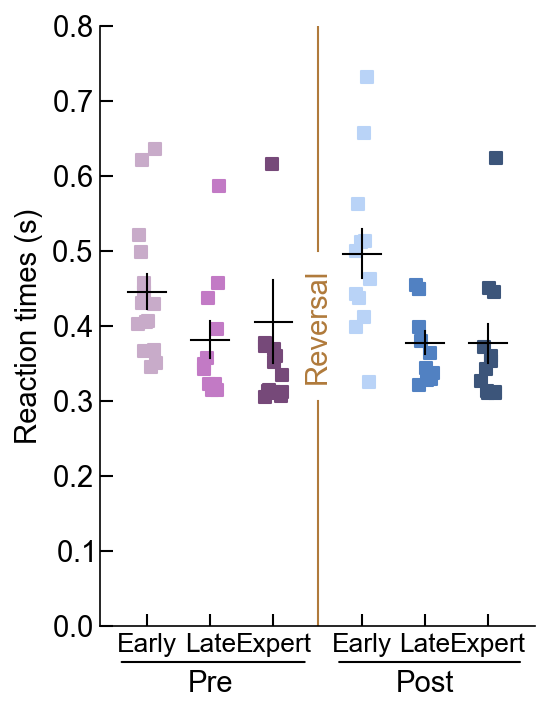

In [24]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(2.9, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.2
#switch_offset = 0
################################################################################################################

#Plot figure

data = data_target
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

sz = 35
width = 0.3

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)
    if idx<3:
        ax.scatter(X-switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
        
    else:
        ax.scatter(X+switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx+switch_offset-width,idx+switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx+switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,0.8])
ylab = ax.set_ylabel('Reaction times (s)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\target_reaction_time_trim.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [25]:
print(mean_reaction_times_target_preearly)
print(mean_reaction_times_target_prelate)
print(mean_reaction_times_target_preexpert)
print(mean_reaction_times_target_postearly)
print(mean_reaction_times_target_postlate)
print(mean_reaction_times_target_postexpert)


{'BS_40': 0.6359463541666667, 'BS_41': 0.40656479012345675, 'BS_42': 0.6212715246636771, 'BS_49': 0.40476196721311475, 'BS_50': 0.44466772277227723, 'BS_51': 0.4296422285714286, 'BS_56': 0.4309545806451613, 'BS_59': 0.36731139318885453, 'BS_67': 0.34587720630372487, 'BS_70': 0.3507238771593091, 'BS_72': 0.402543900990099, 'BS_87': 0.45736812499999996, 'BS_108': 0.367987384341637, 'DS_15': 0.521428747368421, 'DS_19': 0.4989259948979592}
{'BS_40': 0.456737024930748, 'BS_41': nan, 'BS_42': 0.34936998076923076, 'BS_49': 0.4370104347826087, 'BS_50': 0.39626970717423127, 'BS_51': nan, 'BS_56': 0.315234, 'BS_59': 0.3221657894736842, 'BS_67': nan, 'BS_70': 0.5867264473684211, 'BS_72': nan, 'BS_87': 0.32270006993006994, 'BS_108': 0.31409589108910885, 'DS_15': 0.3428980965909091, 'DS_19': 0.3579567567567567}
{'BS_40': 1.1305340000000001, 'BS_41': 0.3600147557003257, 'BS_42': 0.3698482312925171, 'BS_49': 0.31254875, 'BS_50': 0.6162709243697477, 'BS_51': 0.3109890196078431, 'BS_56': 0.305927453416

In [26]:
print(mean_reaction_times_nontarget_preearly)
print(mean_reaction_times_nontarget_prelate)
print(mean_reaction_times_nontarget_preexpert)
print(mean_reaction_times_nontarget_postearly)
print(mean_reaction_times_nontarget_postlate)
print(mean_reaction_times_nontarget_postexpert)


{'BS_40': 0.8551185350318471, 'BS_41': 0.5693795156695157, 'BS_42': 0.6997804656862745, 'BS_49': 0.5810863366336633, 'BS_50': 0.600419205479452, 'BS_51': 0.5146983900523561, 'BS_56': 0.5417254676258993, 'BS_59': 0.41389080291970803, 'BS_67': 0.4225907728706625, 'BS_70': 0.3752643312757202, 'BS_72': 0.41402352051835856, 'BS_87': 0.7096491666666668, 'BS_108': 0.3942864413518887, 'DS_15': 0.675290809178744, 'DS_19': 0.5782503370786516}
{'BS_40': 0.7532028629032258, 'BS_41': nan, 'BS_42': 0.5562778412698413, 'BS_49': 0.5941144061302683, 'BS_50': 0.4495925179856115, 'BS_51': nan, 'BS_56': 0.31248728813559323, 'BS_59': 0.3679611111111111, 'BS_67': nan, 'BS_70': 0.6545967164179104, 'BS_72': nan, 'BS_87': 0.348815041322314, 'BS_108': 0.33280201257861636, 'DS_15': 0.5880639962825278, 'DS_19': 0.43531235042735045}
{'BS_40': 1.441006, 'BS_41': 0.6570045583038868, 'BS_42': 0.7634589928057555, 'BS_49': 0.4494689090909091, 'BS_50': 0.8575935555555555, 'BS_51': 0.31831666666666664, 'BS_56': 0.5014307

meta NOT subset; don't know how to subset; dropped


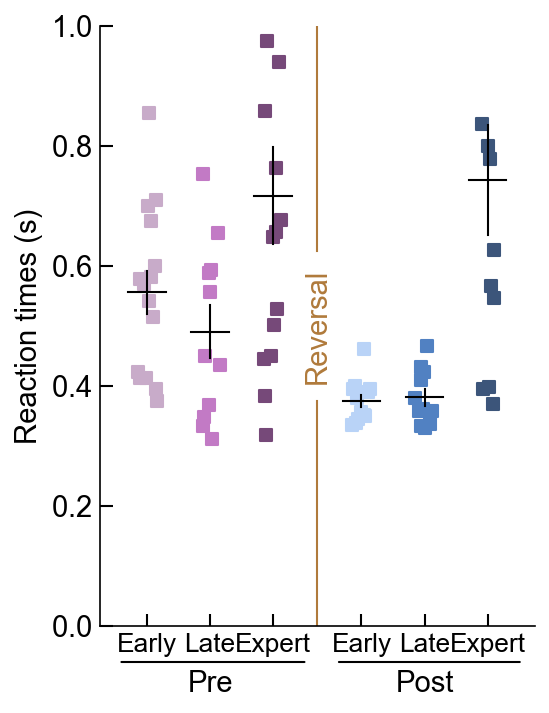

In [27]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(2.9, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.2
#switch_offset = 0
################################################################################################################

#Plot figure

data = data_nontarget
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

sz = 35
width = 0.3

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)

    if idx<3:
        ax.scatter(X-switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
        
    else:
        ax.scatter(X+switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx+switch_offset-width,idx+switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx+switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    
    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,1])
ylab = ax.set_ylabel('Reaction times (s)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\nontarget_reaction_time_trim.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

### Reaction times Stats

In [28]:
data_times_target = SimpleNamespace()
data_times_target.preearly = mean_reactiontimes_target_preearly
data_times_target.prelate = mean_reactiontimes_target_prelate
data_times_target.preexpert = mean_reactiontimes_target_preexpert
data_times_target.postearly = mean_reactiontimes_target_postearly
data_times_target.postlate = mean_reactiontimes_target_postlate
data_times_target.postexpert = mean_reactiontimes_target_postexpert
ilep.nonparametricIndependentStatsCompareToPrevious(data_times_target)
pass

            Source        SS    DF        MS         F     p-unc       np2
0            phase  0.045965   3.0  0.015322  1.163064  0.328346  0.037322
1          context  0.036458   1.0  0.036458  2.767517  0.099674  0.029833
2  phase * context  0.073562   3.0  0.024521  1.861365  0.141812  0.058421
3         Residual  1.185611  90.0  0.013173       NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.340104  0.340104  0.013687
8     post-late  baseline  experimental  0.008905  0.035619  1.279831
9    pre-expert  baseline  experimental  0.275758  0.340104 -0.134440
10     pre-late  baseline  experimental  0.025635  0.051270  0.708610
key preearly has 15 non-nan elements
key prelate has 11 non-nan elements
key preexpert has 15 non-nan elements
key postearly has 12 non-nan elements
key postlate has 11 non-nan elements
key postexpert has 12 non-nan elements


In [29]:
ilep.nonparametricIndependentStatsCompareToOwnEarly(data_times_target)
pass

            Source        SS    DF        MS          F     p-unc       np2
0            phase  0.010487   3.0  0.003496   0.247832  0.862695  0.007765
1          context  0.172465   1.0  0.172465  12.227323  0.000718  0.114032
2  phase * context  0.031514   3.0  0.010505   0.744753  0.528031  0.022978
3         Residual  1.339962  95.0  0.014105        NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.007260  0.011873  1.124143
8     post-late  baseline  experimental  0.008905  0.011873  1.279831
9    pre-expert  baseline  experimental  0.004795  0.011873  0.235447
10     pre-late  baseline  experimental  0.025635  0.025635  0.708610
key preearly has 15 non-nan elements
key prelate has 11 non-nan elements
key preexpert has 15 non-nan elements
key postearly has 12 non-nan elements
key postlate has 11 non-nan elements
key postexpert has 12 non-nan elements


In [30]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

In [31]:
data_times_nontarget = SimpleNamespace()
data_times_nontarget.preearly = mean_reactiontimes_nontarget_preearly
data_times_nontarget.prelate = mean_reactiontimes_nontarget_prelate
data_times_nontarget.preexpert = mean_reactiontimes_nontarget_preexpert
data_times_nontarget.postearly = mean_reactiontimes_nontarget_postearly
data_times_nontarget.postlate = mean_reactiontimes_nontarget_postlate
data_times_nontarget.postexpert = mean_reactiontimes_nontarget_postexpert
ilep.nonparametricIndependentStatsCompareToPrevious(data_times_nontarget)
pass

            Source        SS    DF        MS          F     p-unc       np2
0            phase  0.715288   3.0  0.238429   6.618231  0.000432  0.180736
1          context  0.406510   1.0  0.406510  11.283754  0.001148  0.111407
2  phase * context  0.701675   3.0  0.233892   6.492275  0.000501  0.177908
3         Residual  3.242355  90.0  0.036026        NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.001233  0.004932 -1.509894
8     post-late  baseline  experimental  0.829448  0.829448 -0.137298
9    pre-expert  baseline  experimental  0.042960  0.085920 -0.852769
10     pre-late  baseline  experimental  0.299271  0.399028  0.449161
key preearly has 15 non-nan elements
key prelate has 11 non-nan elements
key preexpert has 15 non-nan elements
key postearly has 12 non-nan elements
key postlate has 11 non-nan elements
key postexpert has 12 non-nan elements


In [32]:
ilep.nonparametricIndependentStatsCompareToOwnEarly(data_times_nontarget)
pass

            Source        SS    DF        MS          F     p-unc       np2
0            phase  0.874493   3.0  0.291498   8.419484  0.000051  0.210035
1          context  0.359042   1.0  0.359042  10.370391  0.001753  0.098418
2  phase * context  0.676241   3.0  0.225414   6.510743  0.000471  0.170539
3         Residual  3.289072  95.0  0.034622        NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.000384  0.001537 -1.577784
8     post-late  baseline  experimental  0.829448  0.829448 -0.137298
9    pre-expert  baseline  experimental  0.184410  0.368820 -0.645589
10     pre-late  baseline  experimental  0.299271  0.399028  0.449161
key preearly has 15 non-nan elements
key prelate has 11 non-nan elements
key preexpert has 15 non-nan elements
key postearly has 12 non-nan elements
key postlate has 11 non-nan elements
key postexpert has 12 non-nan elements


In [38]:
#old (trials)

In [44]:
reactiontimes_target_preearly = []
reactiontimes_target_prelate = []
reactiontimes_target_preexpert = []
reactiontimes_target_postearly = []
reactiontimes_target_postlate = []
reactiontimes_target_postexpert = []

for key,value in reaction_times_target_preearly.items():
    reactiontimes_target_preearly.extend(value)
for key,value in reaction_times_target_prelate.items():
    reactiontimes_target_prelate.extend(value)
for key,value in reaction_times_target_preexpert.items():
    reactiontimes_target_preexpert.extend(value)
for key,value in reaction_times_target_postearly.items():
    reactiontimes_target_postearly.extend(value)
for key,value in reaction_times_target_postlate.items():
    reactiontimes_target_postlate.extend(value)
for key,value in reaction_times_target_postexpert.items():
    reactiontimes_target_postexpert.extend(value)
    
print(len(reactiontimes_target_preearly))
print(len(reactiontimes_target_prelate))
print(len(reactiontimes_target_preexpert))
print(len(reactiontimes_target_postearly))
print(len(reactiontimes_target_postlate))
print(len(reactiontimes_target_postexpert))


8001
5912
8948
9606
8864
10163


In [45]:
print(np.argwhere(np.isnan(reactiontimes_target_preearly)))
print(np.argwhere(np.isnan(reactiontimes_target_prelate)))
print(np.argwhere(np.isnan(reactiontimes_target_preexpert)))
print(np.argwhere(np.isnan(reactiontimes_target_postearly)))
print(np.argwhere(np.isnan(reactiontimes_target_postlate)))
print(np.argwhere(np.isnan(reactiontimes_target_postexpert)))

[]
[]
[]
[]
[]
[]


In [46]:
data_times_target = SimpleNamespace()
data_times_target.preearly = reactiontimes_target_preearly
data_times_target.prelate = reactiontimes_target_prelate
data_times_target.preexpert = reactiontimes_target_preexpert
data_times_target.postearly = reactiontimes_target_postearly 
data_times_target.postlate = reactiontimes_target_postlate
data_times_target.postexpert = reactiontimes_target_postexpert
ilep.nonparametricIndependentStatsCompareToPrevious(data_times_target)
pass

            Source           SS       DF         MS           F  \
0            phase    64.007077      3.0  21.335692  271.863542   
1          context    63.790972      1.0  63.790972  812.836977   
2  phase * context     4.905728      3.0   1.635243   20.836580   
3         Residual  5200.203147  66262.0   0.078479         NaN   

           p-unc       np2  
0  2.154685e-175  0.012159  
1  1.041282e-177  0.012118  
2   1.734134e-13  0.000942  
3            NaN       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  3.558706e-26  7.117413e-26  0.251423
8     post-late  baseline  experimental  9.906774e-12  9.906774e-12  0.253666
9    pre-expert  baseline  experimental  4.810809e-49  1.924324e-48  0.320596
10     pre-late  baseline  experimental  4.184481e-12  5.579308e-12  0.133584


In [39]:
reactiontimes_nontarget_preearly = []
reactiontimes_nontarget_prelate = []
reactiontimes_nontarget_preexpert = []
reactiontimes_nontarget_postearly = []
reactiontimes_nontarget_postlate = []
reactiontimes_nontarget_postexpert = []

for key,value in reaction_times_nontarget_preearly.items():
    reactiontimes_nontarget_preearly.extend(value)
for key,value in reaction_times_nontarget_prelate.items():
    reactiontimes_nontarget_prelate.extend(value)
for key,value in reaction_times_nontarget_preexpert.items():
    reactiontimes_nontarget_preexpert.extend(value)
for key,value in reaction_times_nontarget_postearly.items():
    reactiontimes_nontarget_postearly.extend(value)
for key,value in reaction_times_nontarget_postlate.items():
    reactiontimes_nontarget_postlate.extend(value)
for key,value in reaction_times_nontarget_postexpert.items():
    reactiontimes_nontarget_postexpert.extend(value)
    
print(len(reactiontimes_nontarget_preearly))
print(len(reactiontimes_nontarget_prelate))
print(len(reactiontimes_nontarget_preexpert))
print(len(reactiontimes_nontarget_postearly))
print(len(reactiontimes_nontarget_postlate))
print(len(reactiontimes_nontarget_postexpert))


7092
4413
6023
9300
7446
6502


In [40]:
print(np.argwhere(np.isnan(reactiontimes_nontarget_preearly)))
print(np.argwhere(np.isnan(reactiontimes_nontarget_prelate)))
print(np.argwhere(np.isnan(reactiontimes_nontarget_preexpert)))
print(np.argwhere(np.isnan(reactiontimes_nontarget_postearly)))
print(np.argwhere(np.isnan(reactiontimes_nontarget_postlate)))
print(np.argwhere(np.isnan(reactiontimes_nontarget_postexpert)))


[]
[]
[]
[]
[]
[]


In [41]:
data_times_nontarget = SimpleNamespace()
data_times_nontarget.preearly = reactiontimes_nontarget_preearly
data_times_nontarget.prelate = reactiontimes_nontarget_prelate
data_times_nontarget.preexpert = reactiontimes_nontarget_preexpert
data_times_nontarget.postearly = reactiontimes_nontarget_postearly 
data_times_nontarget.postlate = reactiontimes_nontarget_postlate
data_times_nontarget.postexpert = reactiontimes_nontarget_postexpert
ilep.nonparametricIndependentStatsCompareToPrevious(data_times_nontarget)
pass

            Source           SS       DF         MS           F         p-unc  \
0            phase   230.661699      3.0  76.887233  516.044157  0.000000e+00   
1          context     0.119733      1.0   0.119733    0.803615  3.700189e-01   
2  phase * context    27.020523      3.0   9.006841   60.451229  5.249070e-39   
3         Residual  7841.081728  52627.0   0.148994         NaN           NaN   

        np2  
0  0.028576  
1  0.000015  
2  0.003434  
3       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  1.153170e-08  2.306339e-08 -0.149043
8     post-late  baseline  experimental  1.100542e-05  1.467390e-05 -0.031042
9    pre-expert  baseline  experimental  3.712448e-26  1.484979e-25  0.180192
10     pre-late  baseline  experimental  8.245857e-01  8.245857e-01 -0.029505


In [48]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

In [49]:
2.306339e-08<0.0001

True

In [50]:
1.467390e-05<0.0001

True

In [51]:
1.484979e-25<0.0001

True

In [55]:
8.245857e-01<0.05

False

In [26]:
learning_phases

NameError: name 'leaning_phases' is not defined

### Data Quality Checks

In [12]:
with open('C:\\Users\\insan\\Desktop\\trialsToUsePerDay', 'rb') as f:
    trialsPerDayLoaded = pickle.load(f)

In [13]:
for animal in animals:
    print(animal)
    
    hitrates = []
    falarmrates = []
    pcs = []
    dps = []
    
    for day in animalBehaviors[animal].sessions:
        if day not in learning_phases[animal].pre_expert_days:
            continue
        
        outcomes = np.array(animalBehaviors[animal].sessions[day].outcomes)
        outcomes = outcomes[trialsPerDayLoaded[animal][day]]
        hits = np.sum(np.equal(outcomes,1))
        misses = np.sum(np.equal(outcomes,2))
        falarms = np.sum(np.equal(outcomes,3))
        crejects = np.sum(np.equal(outcomes,4))
        
        hitrates.append(hits/(hits+misses))
        falarmrates.append(falarms/(falarms+crejects))
        pcs.append((hits+crejects)/(hits+misses+falarms+crejects))
        print(f"day {day}: {hits/(hits+misses)}, {falarms/(falarms+crejects)} -> {(hits+crejects)/(hits+misses+falarms+crejects)}")
        
    print(f"{np.mean(hitrates)}, {np.mean(falarmrates)}, {np.mean(pcs)}")
    print()

BS_40
day 16: 0.5, 0.0 -> 0.7169811320754716
0.5, 0.0, 0.7169811320754716

BS_41
day 3: 0.9716981132075472, 0.42718446601941745 -> 0.7751196172248804
day 4: 1.0, 0.44642857142857145 -> 0.7844827586206896
day 5: 1.0, 0.8175675675675675 -> 0.5966666666666667
0.9905660377358491, 0.5637268683385188, 0.7187563475040789

BS_42
day 5: 0.8961038961038961, 0.4349315068493151 -> 0.735
day 6: 0.5471698113207547, 0.02127659574468085 -> 0.75
0.7216368537123254, 0.22810405129699796, 0.7424999999999999

BS_49
day 12: 0.7142857142857143, 0.13043478260869565 -> 0.7843137254901961
day 13: 0.872093023255814, 0.16455696202531644 -> 0.8545454545454545
0.7931893687707641, 0.14749587231700606, 0.8194295900178252

BS_50
day 10: 0.875, 0.35384615384615387 -> 0.7664233576642335
day 11: 0.9425287356321839, 0.5125 -> 0.7245508982035929
0.9087643678160919, 0.43317307692307694, 0.7454871279339133

BS_51
day 6: 1.0, 0.4897959183673469 -> 0.7714285714285715
day 7: 1.0, 0.375 -> 0.8333333333333334
1.0, 0.4323979591836

In [13]:
for animal in animals:
    hit = mean_hit_preexpert[animal]
    falarm = mean_fa_preexpert[animal]
    
    print(f"{animal} hit: {hit}, fa: {falarm}, pc: {(hit+100-falarm) / 2.0}")

NameError: name 'mean_hit_preexpert' is not defined